# Initialize

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib
import mne
import json
import scipy.stats
import scipy.signal as sig
import scipy.io as sio
from scipy.interpolate import interp1d

import pac

import simple_pipeline
import time_pac_after_statistics


In [2]:
# suffix = '_33_36_double_2run'
suffix = '_1_200_double'  # '_1ch_nv'
gamma = [1, 200]
beta = [1, 50]

# gamma = [33, 36]
# beta = [5, 8]

# selected_events = ['S200', 'S201', 'S202']

# selected_channels_pairs = [
#     ('Fz', 'FC3'), ('Fz', 'FC4'),
#     ('Pz', 'FC3'), ('Pz', 'FC4'),
#     ('Fz', 'F3'), ('Fz', 'F4'),
#     ('Pz', 'F3'), ('Pz', 'F4'),
# ]

filt_wind = np.ones((4, 4))
filt_wind /= filt_wind.sum()

with open('config.json') as f:
    config = json.load(f)
    selected_channels = config['channels']
    if 'VEOG' in selected_channels:
        selected_channels.remove('VEOG')
    # selected_channels = ['F3', 'F4', 'FC3', 'FC4', 'Fz', 'Pz']
    # selected_channels = ['FC3','FC4','AF3','AF4','F3','F4','Fz','Pz','Cz','FCz']
    selected_channels_index = [
        config['channels'].index(ch) for ch in selected_channels]

base_path = config['BASE_PATH']
ds_path = os.path.join(base_path, 'ds003490-download')

BASE_DIR = os.path.abspath('')
N = 10
window = np.ones((N, )) / N * 100

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
linestyles = ['-', ':', '--']

groups = ['PD Med Off', 'PD Med On', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

matplotlib.rc('font', size=14)


In [3]:
def plot_pac(pac, high_freq=gamma, low_freq=beta, ax=None, interpolation='None', **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(7, 15))
        ax = fig.subplots()

    im = ax.imshow((pac), origin='lower', interpolation=interpolation,  # 'nearest',
                   extent=low_freq+high_freq,
                   #                    aspect='auto', )
                   aspect=np.diff(low_freq)/np.diff(high_freq), **kwargs)

    if ax is None:
        plt.show()

    return im


# Load Dataset Mvl 2ds

In [4]:
mvl_2ds_mmap_path = os.path.join(ds_path, f'MVL_2ds_{suffix}.mmap')

print(mvl_2ds_mmap_path)

mvl_2ds = np.memmap(mvl_2ds_mmap_path, dtype=float,
                    shape=(3,  # pd_drug_type
                           25,  # Subjects
                           3,  # event_types
                           len(selected_channels),
                           gamma[1] - gamma[0] + 1,  # High Freq
                           beta[1] - beta[0] + 1,  # Low Freq
                           ))


/home/kiani/DS/ds003490-download/MVL_2ds__1_200_double.mmap


In [5]:
mvl_2ds_filtered_mmap_path = os.path.join(
    ds_path, f'MVL_2ds_filtered_{suffix}.mmap')
shape = (3,  # pd_drug_type
         25,  # Subjects
         3,  # event_types
         len(selected_channels),
         (gamma[1] - gamma[0] + 1)//4,  # High Freq
         (beta[1] - beta[0] + 1)//4,  # Low Freq
         )

if os.path.exists(mvl_2ds_filtered_mmap_path):
    mvl_2ds_filtered = np.memmap(
        mvl_2ds_filtered_mmap_path, dtype=float, shape=shape)
else:
    mvl_2ds_filtered = np.memmap(
        mvl_2ds_filtered_mmap_path, dtype=float, shape=shape, mode='w+')
    for i0, i1, i2, i3 in np.ndindex(shape[:-2]):

        A = mvl_2ds[i0, i1, i2, i3]
        window_length = 4
        w = np.ones((window_length, window_length))
        w /= w.sum()
        mvl_2ds_filtered[i0, i1, i2, i3] = \
            sig.convolve2d(A, w, mode='valid')[
            ::window_length, ::window_length]


In [6]:
# ERP

nbtime = 601

erp_mmap_path = os.path.join(ds_path, f'ERPs_{suffix}.mmap')
epochs = np.memmap(erp_mmap_path, dtype=float,
                   shape=(3,  # pd_drug_type
                          25,  # Subjects
                          3,  # event_types
                          2,  # (mean, std)
                          len(selected_channels),  # Channels
                          nbtime,  # time
                          ))


In [7]:
# MVL 2Ds Cross Time
mvl_cross_time_mmap_path = os.path.join(
    ds_path, f'MVL_cross_time_{suffix}.mmap')

mvl_cross_time = np.memmap(mvl_cross_time_mmap_path, dtype=float,
                           shape=(3,  # pd_drug_type
                                  25,  # Subjects
                                  3,  # event_types
                                  len(selected_channels),  # Selected Channels
                                  len(selected_channels),  # Selected Channels
                                  gamma[1] - gamma[0] + 1,  # High Freq
                                  beta[1] - beta[0] + 1,  # Low Freq
                                  6
                                  ))


In [8]:
mvl_cross_time_filtered_mmap_path = os.path.join(
    ds_path, f'MVL_cross_time_filtered_{suffix}.mmap')
shape = (3,  # pd_drug_type
         25,  # Subjects
         3,  # event_types
         len(selected_channels),
         (gamma[1] - gamma[0] + 1)//4,  # High Freq
         (beta[1] - beta[0] + 1)//4,  # Low Freq
         6
         )

if os.path.exists(mvl_cross_time_filtered_mmap_path):
    mvl_cross_time_filtered = np.memmap(
        mvl_cross_time_filtered_mmap_path, dtype=float, shape=shape)
else:
    mvl_cross_time_filtered = np.memmap(
        mvl_cross_time_filtered_mmap_path, dtype=float, shape=shape, mode='w+')
    for i0, i1, i2, i3, i7 in np.ndindex((3, 25, 3, len(selected_channels), 6)):
        A = mvl_cross_time[i0, i1, i2, i3, i3, :, :, i7]
        window_length = 4
        w = np.ones((window_length, window_length))
        w /= w.sum()
        mvl_cross_time_filtered[i0, i1, i2, i3, :, :, i7] = \
            sig.convolve2d(A, w, mode='valid')[
            ::window_length, ::window_length]


In [9]:
mvl_time_mmap_path = os.path.join(ds_path, f'PAC_time_{suffix}.mmap')
mvl_time = np.memmap(mvl_time_mmap_path, dtype=float,
                     shape=(3,  # pd_drug_type
                            25,  # Subjects
                            3,  # event_types
                            len(selected_channels),
                            gamma[1] - gamma[0] + 1,  # High Freq
                            beta[1] - beta[0] + 1,  # Low Freq
                            6,  # Time sections
                            ))

# mx = mvl_time.max()
# nrm = np.linalg.norm(mvl_time)
# zrs = np.sum(mvl_time == 0)

# print(mx, nrm, zrs, mvl_time.shape)


In [10]:
mvl_time_filtered_mmap_path = os.path.join(
    ds_path, f'PAC_time_filtered_{suffix}.mmap')
shape = (3,  # pd_drug_type
         25,  # Subjects
         3,  # event_types
         len(selected_channels),
         (gamma[1] - gamma[0] + 1)//4,  # High Freq
         (beta[1] - beta[0] + 1)//4,  # Low Freq
         6
         )

if os.path.exists(mvl_time_filtered_mmap_path):
    mvl_time_filtered_mmap = np.memmap(
        mvl_time_filtered_mmap_path, dtype=float, shape=shape)
else:
    mvl_time_filtered_mmap = np.memmap(
        mvl_time_filtered_mmap_path, dtype=float, shape=shape, mode='w+')
    for i0, i1, i2, i3, i6 in np.ndindex((3, 25, 3, len(selected_channels), 6)):
        A = mvl_time[i0, i1, i2, i3, :, :, i6]
        window_length = 4
        w = np.ones((window_length, window_length))
        w /= w.sum()
        mvl_time_filtered_mmap[i0, i1, i2, i3, :, :, i6] = \
            sig.convolve2d(A, w, mode='valid')[
            ::window_length, ::window_length]
        
print(np.linalg.norm(mvl_time_filtered_mmap), mvl_time_filtered_mmap.max())


1546254712456754.8 37898248475812.64


In [11]:
selected_channels_corss = ['FC3', 'FC4', 'AF3',
                           'AF4', 'F3', 'F4', 'Fz', 'Pz', 'Cz', 'FCz']
selected_channels_corss = ['F3', 'F4', 'FC3', 'FC4', 'Fz', 'Pz', 'Cz']
# selected_channels = config['channels']
if 'VEOG' in selected_channels_corss:
    selected_channels_corss.remove('VEOG')
selected_channels_cross_index = [
    config['channels'].index(ch) for ch in selected_channels_corss]

selected_channels_pairs = [
    #     ('Fz', 'FC3'), ('Fz', 'FC4'),
    #     ('Pz', 'FC3'), ('Pz', 'FC4'),
    #     ('Cz', 'FC3'), ('Cz', 'FC4'),

    ('Fz', 'F3'), ('Fz', 'F4'),
    ('Pz', 'F3'), ('Pz', 'F4'),
    #     ('Cz', 'F3'), ('Cz', 'F4'),

    #     ('Cz', 'Fz'), ('Cz', 'Pz'),
    #     ('Pz', 'Cz'), ('Fz', 'Cz'),
    #     ('Pz', 'Fz'),
    #     ('Fz', 'Pz'),
]

shape = (3,  # pd_drug_type
         25,
         6,  # event_types
         len(selected_channels_corss),
         len(selected_channels_corss),
         4,  # High Freq
         4,  # Low Freq
         6
         )

MVL_cross_mmap_path = os.path.join(
    ds_path, f'MVL_cross_time_{"_33_36_double_2run_cz"}.mmap')
print(MVL_cross_mmap_path)

MVL_cross = np.memmap(MVL_cross_mmap_path, dtype=float, shape=shape)
MVL_cross.shape

mx = MVL_cross.max()
nrm = np.linalg.norm(MVL_cross)
zrs = np.sum(MVL_cross == 0)

print(mx, nrm, zrs, MVL_cross.shape)


/home/kiani/DS/ds003490-download/MVL_cross_time__33_36_double_2run_cz.mmap
4.092524940020433 368.78232265269287 14112 (3, 25, 6, 7, 7, 4, 4, 6)


In [12]:
10368/16/27


24.0

# Topo plots 3\*3 All

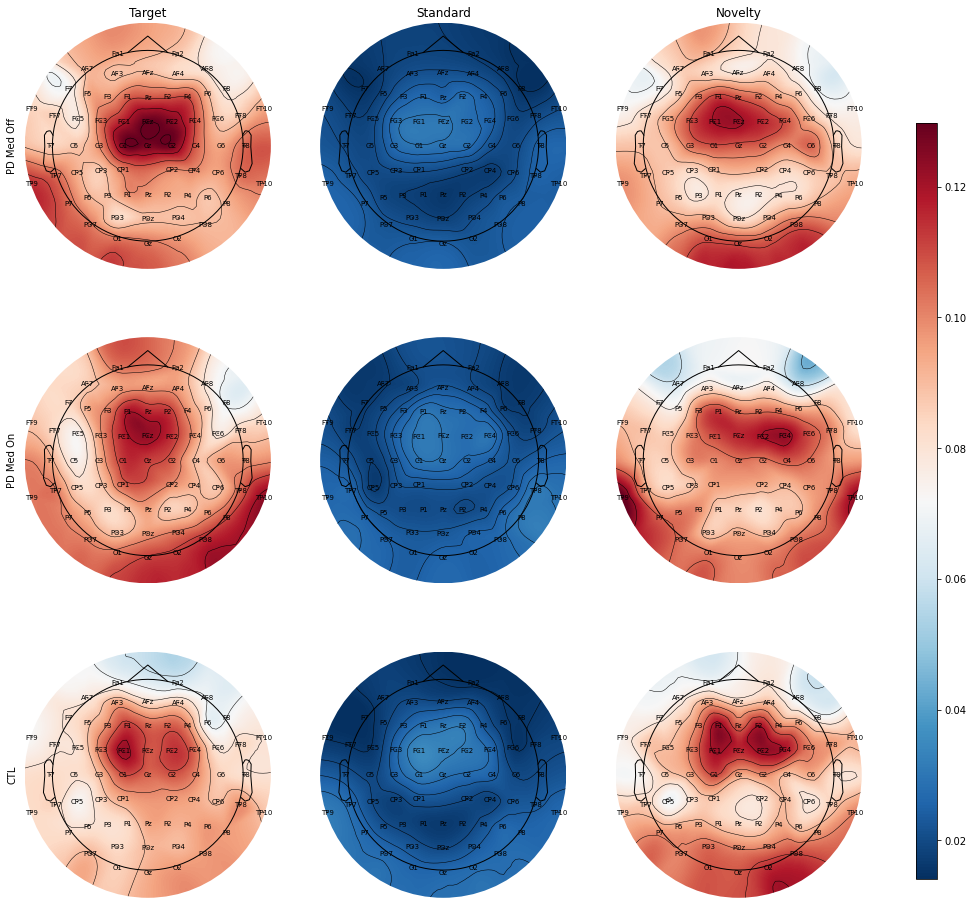

In [12]:
mvl_selected_freq = mvl_2ds_filtered[:, :, :, :, 8, 1].mean(axis=1) / 1e12

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmin = mvl_selected_freq.min()
vmax = mvl_selected_freq.max()
for i, j in np.ndindex((3, 3)):
    data = mvl_selected_freq[i, j].reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=axs[i, j], show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)

plt.savefig('plots/topographic_all.png')
plt.savefig('plots/topographic_all.svg')
plt.show()


In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, :].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, :].mean(axis=1).max() / 1e12

for time in range(6):
    mvl_selected_freq = mvl_time_filtered_mmap[:, :, :, :, 8, 1, time].mean(
        axis=1) / 1e12

    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
    for i, j in np.ndindex((3, 3)):
        data = mvl_selected_freq[i, j].reshape((-1, 1))
        mvl_evoked = mne.EvokedArray(data, mne_info)
        mvl_evoked.set_montage(montage)
        im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                      mvl_evoked.info, axes=axs[i,
                                                                j], show=False,
                                      names=selected_channels, cmap='RdBu_r',
                                      vlim=(vmin, vmax))

    for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)

    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    clb = fig.colorbar(im, cax=cbar_ax)

    axs[2, 1].set_xlabel(times[time])

    plt.show()


In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

times = [
    # '-200-0', '0-200',
    '200-400', '400-600',
    # '600-800', '800-1000'
]

vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, :].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, :].mean(axis=1).max() / 1e12

for ev_i, ev in enumerate(event_types):
    fig, axs = plt.subplots(3, len(times), sharex=True,
                            sharey=True, figsize=(len(times)*5, 15))
    for t_i in range(len(times)):
        mvl_selected_freq = mvl_time_filtered_mmap[:, :, ev_i, :, 8, 1, t_i+2].mean(
            axis=1) / 1e12
        for gr_i, gr in enumerate(groups):
            data = mvl_selected_freq[gr_i].reshape((-1, 1))
            mvl_evoked = mne.EvokedArray(data, mne_info)
            mvl_evoked.set_montage(montage)
            im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                          mvl_evoked.info, axes=axs[gr_i, t_i],
                                          show=False,
                                          names=selected_channels,  # show_names=True,
                                          cmap='RdBu_r', vlim=(vmin, vmax))

    for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[i, 0].yaxis.set_visible(True)

    for i in range(len(times)):
        axs[0, i].set_title(times[i])
        axs[-1, i].xaxis.set_visible(True)

    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    clb = fig.colorbar(im, cax=cbar_ax)

    # axs[2, 1].set_xlabel(times[time])
    plt.savefig(f'plots/topography_event_{ev}_time.png')
    plt.savefig(f'plots/topography_event_{ev}_time.svg')
    plt.show()


In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

times = [
    '-200-0', '0-200',
    '200-400', '400-600',
    '600-800', '800-1000'
]

vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, :].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, :].mean(axis=1).max() / 1e12

for ev_i, ev in enumerate(event_types):
    # fig, axs = plt.subplots(3, len(times), sharex=True,
    #                         sharey=True, figsize=(30, 15))
    for t_i in range(6):
        mvl_selected_freq = mvl_time_filtered_mmap[:, :, ev_i, :, 8, 1, t_i].mean(
            axis=1) / 1e12
        for gr_i, gr in enumerate(groups):
            data = mvl_selected_freq[gr_i].reshape((-1, 1))
            mvl_evoked = mne.EvokedArray(data, mne_info)
            mvl_evoked.set_montage(montage)
            im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                          # axes=axs[gr_i, t_i],
                                          mvl_evoked.info,
                                          show=False,
                                          names=selected_channels, cmap='RdBu_r',
                                          vlim=(vmin, vmax))
            print(
                f'plots/topography_time/{ev}/{gr}/topography_event_{ev}_{times[t_i]}_{gr}')
            if not os.path.exists(f'plots/topography_time/{ev}/{gr}/'):
                os.makedirs(f'plots/topography_time/{ev}/{gr}/')
            plt.savefig(
                f'plots/topography_time/{ev}/{gr}/topography_time_{ev}_{times[t_i]}_{gr}.png')
            plt.close()
            # plt.show()


In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

times = [
    '-200-0', '0-200',
    '200-400', '400-600',
    '600-800', '800-1000'
]

vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, :].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, :].mean(axis=1).max() / 1e12


fig, axs = plt.subplots(3, 2, sharex=True,
                        sharey=True, figsize=(15, 15))
for gr_i, gr in enumerate(groups):
    for i, chi, ch in zip(range(2), [1, 12], ['Fz', 'Pz']):

        # ['#1f77b4', '#ff7f0e', '#2ca02c']
        # Fz = 1
        # Pz = 12

        mvl_selected_Fz = mvl_time_filtered_mmap[gr_i, :, 0, chi, 8, 1, :].mean(
            axis=0) / 1e12
        std_Fz = mvl_time_filtered_mmap[gr_i,
                                        :, 0, chi, 8, 1, :].std(axis=0) / 1e12

        # mvl_selected_Pz = mvl_time_filtered_mmap[gr_i, :, 0, Pz, 8, 1, :].mean(
        #     axis=0) / 1e12
        # std_Pz = mvl_time_filtered_mmap[gr_i, :, 0, Pz, 8, 1, :].std(axis=0) / 1e12

        # axs[gr_i].errorbar(times, mvl_selected_Fz, yerr=std_Fz, color='#1f77b4',
        #                     marker='+', label='Fz', elinewidth=0.5)
        # axs[gr_i].errorbar(times, mvl_selected_Pz, yerr=std_Pz, color='#2ca02c',
        #                     marker='+', label='Pz', elinewidth=0.5)
        axs[gr_i, i].plot(times, mvl_selected_Fz,
                          '#1f77b4', label=ch, marker='+')
        axs[gr_i, i].plot(times, mvl_selected_Fz + std_Fz /
                          2, '#2ca02c', ls='--', lw=1)
        axs[gr_i, i].plot(times, mvl_selected_Fz - std_Fz /
                          2, '#2ca02c', ls='--', lw=1)
        axs[gr_i, i].set_ylim([0, 0.8])
        # axs[gr_i].plot(times, mvl_selected_Pz, '#ff7f0e', label='Pz')
        # axs[gr_i].plot(times, mvl_selected_Pz + std_Pz, '#ff7f0e', ls='--', lw=0.5)
        # axs[gr_i].plot(times, mvl_selected_Pz - std_Pz, '#ff7f0e', ls='--', lw=0.5)

        # axs[gr_i, i].grid()
        # axs[gr_i, i].legend()

# for i in range(3):
#     axs[i, 0].set_ylabel(groups[i])
#     axs[i, 0].yaxis.set_visible(True)

for i, ch in enumerate(['Fz', 'Pz']):
    #     axs[0, i].set_title(ch)
    axs[-1, i].xaxis.set_ticklabels([])  # set_visible(False)

    # axs[2, 1].set_xlabel(times[time])
plt.savefig(f'plots/event_dynamics_time.png')
plt.savefig(f'plots/event_dynamics_time.svg')
plt.show()


In [ ]:
selected_channels_corss = ['FC3', 'FC4', 'AF3',
                           'AF4', 'F3', 'F4', 'Fz', 'Pz', 'Cz', 'FCz']
# selected_channels = config['channels']
if 'VEOG' in selected_channels_corss:
    selected_channels_corss.remove('VEOG')
selected_channels_cross_index = [
    config['channels'].index(ch) for ch in selected_channels_corss]

selected_channels_pairs = [
    #     ('Fz', 'FC3'), ('Fz', 'FC4'),
    #     ('Pz', 'FC3'), ('Pz', 'FC4'),
    #     ('Cz', 'FC3'), ('Cz', 'FC4'),

    ('Fz', 'F3'),  # ('Fz', 'F4'),
    ('Pz', 'F3'),  # ('Pz', 'F4'),
    #     ('Cz', 'F3'), ('Cz', 'F4'),

    #     ('Cz', 'Fz'), ('Cz', 'Pz'),
    #     ('Pz', 'Cz'), ('Fz', 'Cz'),
    #     ('Pz', 'Fz'),
    #     ('Fz', 'Pz'),
]


times = [
    '-200-0', '0-200',
    '200-400', '400-600',
    '600-800', '800-1000'
]

fig, axs = plt.subplots(3, len(selected_channels_pairs), sharex=True,
                        sharey=True, figsize=(15, 15))

for i, j in np.ndindex((3, len(selected_channels_pairs))):
    mvl_selected = MVL_cross[i, :, 0, :, :, 32:35,
                             4:7, :].sum(axis=(3, 4)).mean(axis=0) / 1e12 / 16
    std = MVL_cross[i, :, 0, :, :, 32:35,
                    4:7, :].sum(axis=(3, 4)).std(axis=0) / 1e12 / 16

    cha, chb = selected_channels_pairs[j]
    inda, indb = selected_channels_corss.index(
        cha), selected_channels_corss.index(chb)

    # ['#1f77b4', '#ff7f0e', '#2ca02c']
    # Fz = 1
    # Pz = 12

    # (3, 25, 3, 10, 10, 200, 50, 6)

    mvl_selected_Fz = mvl_selected[inda, indb]
    std_Fz = std[inda, indb]

    # mvl_selected_Pz = mvl_time_filtered_mmap[gr_i, :, 0, Pz, 8, 1, :].mean(
    #     axis=0) / 1e12
    # std_Pz = mvl_time_filtered_mmap[gr_i, :, 0, Pz, 8, 1, :].std(axis=0) / 1e12

    # axs[gr_i].errorbar(times, mvl_selected_Fz, yerr=std_Fz, color='#1f77b4',
    #                     marker='+', label='Fz', elinewidth=0.5)
    # axs[gr_i].errorbar(times, mvl_selected_Pz, yerr=std_Pz, color='#2ca02c',
    #                     marker='+', label='Pz', elinewidth=0.5)
    axs[i, j].plot(times, mvl_selected_Fz, '#1f77b4', label='ch', marker='+')
    axs[i, j].plot(times, mvl_selected_Fz + std_Fz /
                   2, '#2ca02c', ls='--', lw=1)
    axs[i, j].plot(times, mvl_selected_Fz - std_Fz /
                   2, '#2ca02c', ls='--', lw=1)
    # axs[i, j].set_ylim([0, 0.8])
    # axs[gr_i].plot(times, mvl_selected_Pz, '#ff7f0e', label='Pz')
    # axs[gr_i].plot(times, mvl_selected_Pz + std_Pz, '#ff7f0e', ls='--', lw=0.5)
    # axs[gr_i].plot(times, mvl_selected_Pz - std_Pz, '#ff7f0e', ls='--', lw=0.5)

    # axs[i, j].grid()
    # axs[gr_i, i].legend()

for i in range(3):
    #     axs[i, 0].set_ylabel(groups[i])
    axs[i, 0].yaxis.set_visible(True)

for i, ch in enumerate(selected_channels_pairs):
    # axs[0, i].set_title(ch)
    axs[-1, i].xaxis.set_ticklabels([])  # set_visible(False)

    # axs[2, 1].set_xlabel(times[time])
plt.savefig(f'plots/event_dynamics_time_cross.png')
plt.savefig(f'plots/event_dynamics_time_cross.svg')
plt.show()


# Pv for channels

In [18]:
chs = ['Fz', 'Pz']
res = []
for i, j in itertools.combinations(range(3), 2):
    for ch in chs:
        mvla = mvl_2ds_filtered[i, :, 0, config['channels'].index(ch), 8, 1]
        mvlb = mvl_2ds_filtered[j, :, 0, config['channels'].index(ch), 8, 1]
        pv = scipy.stats.ttest_ind(mvla, mvlb)
        res.append({'name': 'Total epoch Single Channel',
                   'A': groups[i], 'B': groups[j], 'phase': ch, 'amp': ch, 'Pv': pv[1]})

chs = ['Fz', 'Pz']
for i, j in itertools.combinations(range(3), 2):
    for ch in chs:
        for t in range(6):
            mvla = mvl_time_filtered_mmap[i, :, 0,
                                          config['channels'].index(ch), 8, 1, t]
            mvlb = mvl_time_filtered_mmap[j, :, 0,
                                          config['channels'].index(ch), 8, 1, t]
            pv = scipy.stats.ttest_ind(mvla, mvlb)
            res.append({'name': f'{times[t]} Cross Single Channel', 'A': groups[i],
                       'B': groups[j], 'phase': ch, 'amp': ch, 'Pv': pv[1]})

chps = [
    ('Fz', 'FC3'), ('Fz', 'FC4'),
    ('Pz', 'FC3'), ('Pz', 'FC4'),
    #     ('Cz', 'FC3'), ('Cz', 'FC4'),

    ('Fz', 'F3'), ('Fz', 'F4'),
    ('Pz', 'F3'), ('Pz', 'F4'),
    #     ('Cz', 'F3'), ('Cz', 'F4'),

    #     ('Cz', 'Fz'), ('Cz', 'Pz'),
    #     ('Pz', 'Cz'), ('Fz', 'Cz'),
    #     ('Pz', 'Fz'),
    #     ('Fz', 'Pz'),
]
chpind = ['FC3', 'FC4', 'AF3', 'AF4', 'F3', 'F4', 'Fz', 'Pz', 'Cz', 'FCz']

for i, j in itertools.combinations(range(3), 2):
    for cha, chb in chps:
        for t in range(6):
            mvla = MVL_cross[i, :, 0, chpind.index(cha), chpind.index(
                chb), 32:35, 4:7, t].sum(axis=(1, 2))
            mvlb = MVL_cross[j, :, 0, chpind.index(cha), chpind.index(
                chb), 32:35, 4:7, t].sum(axis=(1, 2))
            pv = scipy.stats.ttest_ind(mvla, mvlb)
            res.append({'name': f'{times[t]} Cross Channel', 'A': groups[i],
                       'B': groups[j], 'amp': cha, 'phase': chb, 'Pv': pv[1]})

df = pd.DataFrame(res)

df.to_csv('plots/Pv for channels.csv')  # df

df[df.Pv < 0.05]


IndexError: index 7 is out of bounds for axis 3 with size 7

In [ ]:
mvl_cross_time_filtered.shape


In [14]:
MVL_cross.shape
list(itertools.combinations(range(3), 2))


[(0, 1), (0, 2), (1, 2)]

# 2d Maps

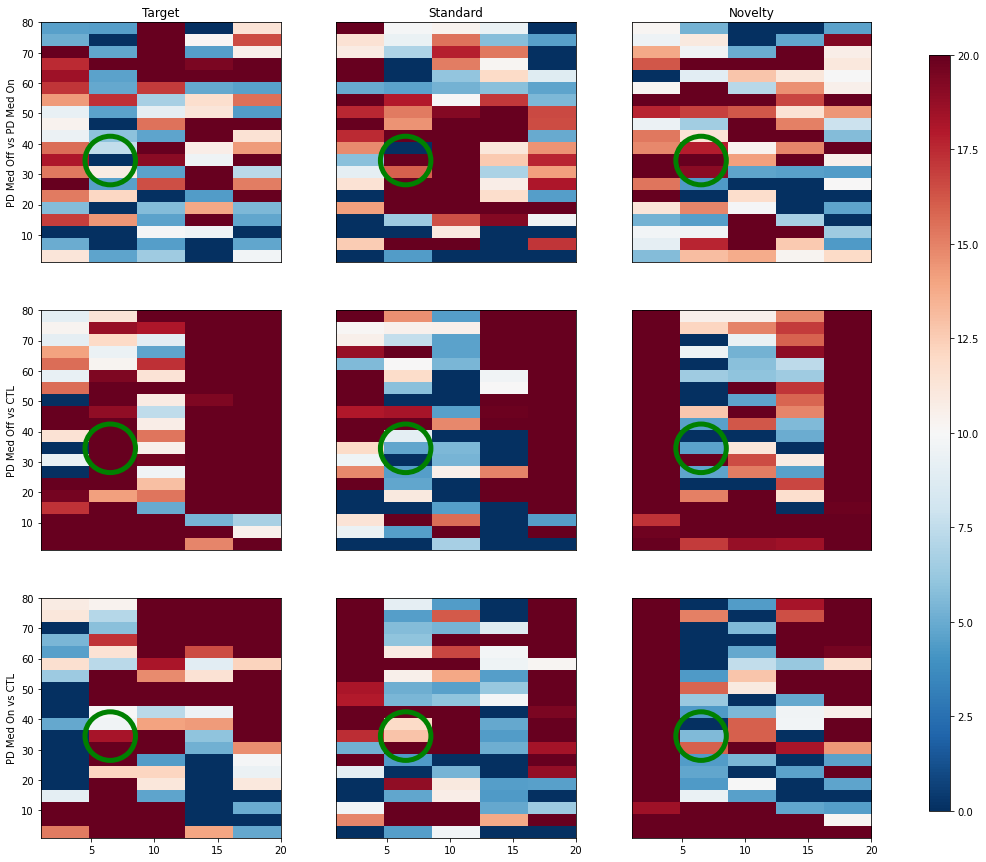

In [12]:
# selected_channels = ['FC3','FC4','AF3','AF4','F3','F4','Fz','Pz','Cz','FCz']
selected_channels = config['channels']
if 'VEOG' in selected_channels:
    selected_channels.remove('VEOG')
selected_channels_index = [
    config['channels'].index(ch) for ch in selected_channels]

shape = (3,  # pd_drug_type
         3,  # event_types
         len(selected_channels),
         (gamma[1] - gamma[0] + 1),  # High Freq
         (beta[1] - beta[0] + 1),  # Low Freq
         )
shape = (3,  # pd_drug_type
         3,  # event_types
         len(selected_channels),
         80//4,  # High Freq
         20//4,  # Low Freq
         )
log_pv_2d = np.zeros(shape)


for i, j, ch in np.ndindex((3, 3, len(selected_channels))):
    a, b = list(itertools.combinations(range(3), 2))[i]
    if (a, b) == (0, 1):
        t, p = scipy.stats.ttest_rel(mvl_2ds_filtered[a, :, j, selected_channels_index[ch], :80//4, :20//4],
                                 mvl_2ds_filtered[b, :, j, selected_channels_index[ch], :80//4, :20//4])
    else:
        t, p = scipy.stats.ttest_ind(mvl_2ds_filtered[a, :, j, selected_channels_index[ch], :80//4, :20//4],
                                 mvl_2ds_filtered[b, :, j, selected_channels_index[ch], :80//4, :20//4])
#     t, p = scipy.stats.ttest_ind(mvl_time_filtered_mmap[a, :, j, selected_channels_index[ch], :80//4, :20//4, 3],
#                                  mvl_time_filtered_mmap[b, :, j, selected_channels_index[ch], :80//4, :20//4, 3],)
#     t, p = scipy.stats.ttest_ind(mvl_time_filtered_mmap[a, :, j, selected_channels_index[ch], :80//4, :20//4, 4],
#                                  mvl_time_filtered_mmap[b, :, j, selected_channels_index[ch], :80//4, :20//4, 4],)
    p[p > 0.05] = 1
    log_pv_2d[i, j, ch] = -np.log2(p)


sum_log_pv_2d = log_pv_2d.sum(axis=2)

vmin, vmax = 0, 20  # sum_log_pv_2d.max()

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
for i, j in itertools.product(range(3), range(3)):
    im = plot_pac(sum_log_pv_2d[i, j], ax=axs[i, j], high_freq=[1, 80], low_freq=[1, 20], cmap='RdBu_r',
                  vmin=vmin, vmax=vmax)
    axs[i, j].xaxis.set_visible(False)
    axs[i, j].yaxis.set_visible(False)

for i in range(3):
    a, b = list(itertools.combinations(range(3), 2))[i]
    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)

# circ = mpatches.Ellipse((6.5, 34.5), 4, 16, color='g', fill=False, lw=5)
# axs[1, 0].add_patch(circ)
# circ = mpatches.Ellipse((6.5, 34.5), 4, 16, color='g', fill=False, lw=5)
# axs[2, 0].add_patch(circ)

for i, j in np.ndindex((3, 3)):
    circ = mpatches.Ellipse((6.5, 34.5), 4, 16, color='g', fill=False, lw=5)
    axs[i, j].add_patch(circ)


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)

plt.savefig('plots/pvalue for channels 2d.png')

plt.show()


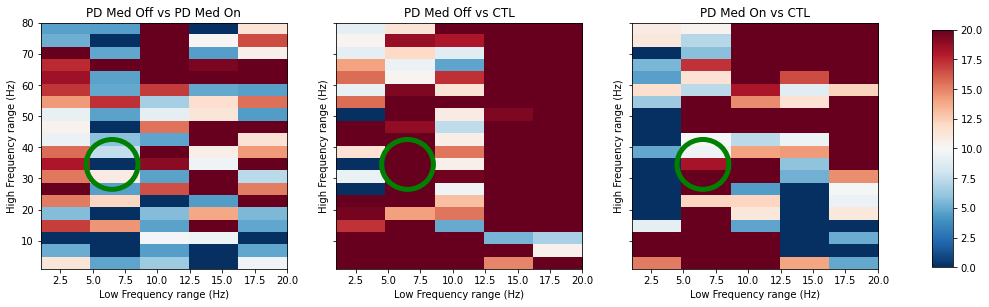

In [13]:
# selected_channels = ['FC3','FC4','AF3','AF4','F3','F4','Fz','Pz','Cz','FCz']
selected_channels = config['channels']
if 'VEOG' in selected_channels:
    selected_channels.remove('VEOG')
selected_channels_index = [
    config['channels'].index(ch) for ch in selected_channels]

shape = (3,  # pd_drug_type
         3,  # event_types
         len(selected_channels),
         (gamma[1] - gamma[0] + 1),  # High Freq
         (beta[1] - beta[0] + 1),  # Low Freq
         )
shape = (3,  # pd_drug_type
         3,  # event_types
         len(selected_channels),
         80//4,  # High Freq
         20//4,  # Low Freq
         )
log_pv_2d = np.zeros(shape)


for i, j, ch in np.ndindex((3, 3, len(selected_channels))):
    a, b = list(itertools.combinations(range(3), 2))[i]
    if (a, b) == (0, 1):
        t, p = scipy.stats.ttest_rel(mvl_2ds_filtered[a, :, j, selected_channels_index[ch], :80//4, :20//4],
                                     mvl_2ds_filtered[b, :, j, selected_channels_index[ch], :80//4, :20//4])
    else:
        t, p = scipy.stats.ttest_ind(mvl_2ds_filtered[a, :, j, selected_channels_index[ch], :80//4, :20//4],
                                     mvl_2ds_filtered[b, :, j, selected_channels_index[ch], :80//4, :20//4])
    # t, p = scipy.stats.ttest_ind(mvl_2ds_filtered[a, :, j, selected_channels_index[ch], :80//4, :20//4],
    #                              mvl_2ds_filtered[b, :, j, selected_channels_index[ch], :80//4, :20//4])
#     t, p = scipy.stats.ttest_ind(mvl_time_filtered_mmap[a, :, j, selected_channels_index[ch], :80//4, :20//4, 3],
#                                  mvl_time_filtered_mmap[b, :, j, selected_channels_index[ch], :80//4, :20//4, 3],)
#     t, p = scipy.stats.ttest_ind(mvl_time_filtered_mmap[a, :, j, selected_channels_index[ch], :80//4, :20//4, 4],
#                                  mvl_time_filtered_mmap[b, :, j, selected_channels_index[ch], :80//4, :20//4, 4],)
    p[p > 0.05] = 1
    log_pv_2d[i, j, ch] = -np.log2(p)


sum_log_pv_2d = log_pv_2d.sum(axis=2)

vmin, vmax = sum_log_pv_2d.min(), 20  # sum_log_pv_2d.max()

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 15))
for i in range(3):
    im = plot_pac(sum_log_pv_2d[i, 0], ax=axs[i], high_freq=[1, 80], low_freq=[1, 20], cmap='RdBu_r',
                  vmin=vmin, vmax=vmax)

    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)

for i in range(3):
    a, b=list(itertools.combinations(range(3), 2))[i]
    # axs[i].set_ylabel(f'{groups[a]} vs {groups[b]}')
    # axs[i].set_title(event_types[0])
    axs[i].set_ylabel(f'High Frequency range (Hz)')
    axs[i].set_xlabel(f'Low Frequency range (Hz)')
    axs[i].set_title(f'{groups[a]} vs {groups[b]}')

    axs[i].xaxis.set_visible(True)
    axs[i].yaxis.set_visible(True)

    circ=mpatches.Ellipse(
        (6.5, 34.5), 4, 16,
        # color='#F391A0',
        color='g',
        fill=False, lw=5)
    axs[i].add_patch(circ)

cbar_ax=fig.add_axes([0.95, 0.39, 0.02, 0.22])
clb=fig.colorbar(im, cax=cbar_ax)
# clb.ax.plot([0, 1], [10, 10], 'g')  # my data is between 0 and 1

plt.savefig('plots/pvalue for channels 2d target only.png')
plt.savefig('plots/pvalue for channels 2d target only.svg')


plt.show()


In [16]:
lpv_dev_off_ctl = sum_log_pv_2d[i, 0]
lpv_dev_off_ctl_sort = lpv_dev_off_ctl.ravel().copy()
lpv_dev_off_ctl_sort.sort()
index = np.linspace(
    1, lpv_dev_off_ctl_sort.shape[0], lpv_dev_off_ctl_sort.shape[0])
sum_log_pv_2d.shape, lpv_dev_off_ctl_sort.shape[0]


((3, 3, 20, 5), 100)

59 9.087551760209239 7.543278279671204
93 7.4743836321109125 6.750635604381463
69 8.9673967195454 7.341110691615452


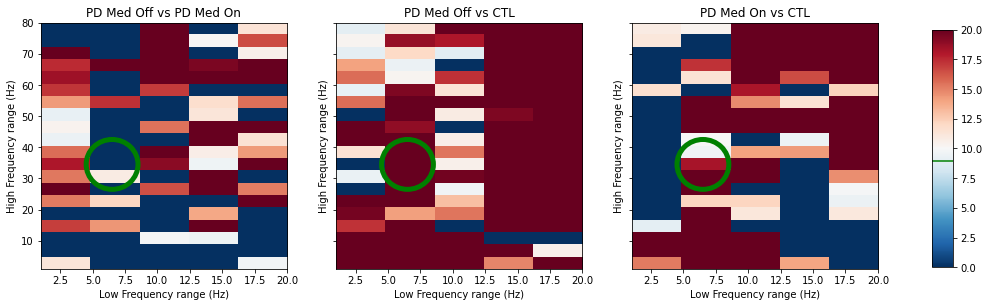

In [19]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 15))

for i in range(3):
    lpv_dev_off_ctl = sum_log_pv_2d[i, 0]
    lpv_dev_off_ctl_sort = lpv_dev_off_ctl.ravel().copy()
    lpv_dev_off_ctl_sort.sort()
    index = np.linspace(
        1, lpv_dev_off_ctl_sort.shape[0], lpv_dev_off_ctl_sort.shape[0])
    criteria = index * 0.05 / lpv_dev_off_ctl_sort.shape[0] / 63
    selected_index = int(
        index[lpv_dev_off_ctl_sort[::-1] > -np.log(criteria)].max())
    print(selected_index, lpv_dev_off_ctl_sort[::-1][selected_index - 1], lpv_dev_off_ctl_sort[::-1][selected_index])
    # (a, b, i, j), mvl_2ds_filtered.shape, mvl_2ds_filtered[a, :, j, selected_channels_index[ch], :80//4, :20//4].shape

    drawable = np.zeros(sum_log_pv_2d[i, 0].shape)

    drawable[sum_log_pv_2d[i, 0] > lpv_dev_off_ctl_sort[::-1][selected_index - 1]] = \
        sum_log_pv_2d[i, 0][sum_log_pv_2d[i, 0] >
                            lpv_dev_off_ctl_sort[::-1][selected_index - 1]]

    im = plot_pac(drawable, ax=axs[i], high_freq=[1, 80], low_freq=[1, 20], cmap='RdBu_r',
                  vmin=vmin, vmax=vmax)
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)

for i in range(3):
    a, b = list(itertools.combinations(range(3), 2))[i]
    # axs[i].set_ylabel(f'{groups[a]} vs {groups[b]}')
    # axs[i].set_title(event_types[0])
    axs[i].set_ylabel(f'High Frequency range (Hz)')
    axs[i].set_xlabel(f'Low Frequency range (Hz)')
    axs[i].set_title(f'{groups[a]} vs {groups[b]}')

    axs[i].xaxis.set_visible(True)
    axs[i].yaxis.set_visible(True)

    circ = mpatches.Ellipse(
        (6.5, 34.5), 4, 16,
        # color='#F391A0',
        color='g',
        fill=False, lw=5)
    axs[i].add_patch(circ)

cbar_ax = fig.add_axes([0.95, 0.39, 0.02, 0.22])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.plot([0, 1], [lpv_dev_off_ctl_sort[::-1][selected_index - 1]]*2, 'g')

plt.savefig('plots/pvalue for channels 2d target only bar.png')
plt.savefig('plots/pvalue for channels 2d target only bar.svg')

plt.show()


In [24]:
20*5*63

6300

## 2D maps Cross

In [ ]:
# selected_channels = ['FC3', 'FC4', 'AF3',
#                      'AF4', 'F3', 'F4', 'Fz', 'Pz', 'Cz', 'FCz']
# selected_channels = config['channels']
if 'VEOG' in selected_channels:
    selected_channels.remove('VEOG')
selected_channels_index = [
    config['channels'].index(ch) for ch in selected_channels]

shape = (3,  # pd_drug_type
         3,  # event_types
         len(selected_channels),
         len(selected_channels),
         (gamma[1] - gamma[0] + 1),  # High Freq
         (beta[1] - beta[0] + 1),  # Low Freq
         )
shape = (3,  # pd_drug_type
         3,  # event_types
         len(selected_channels),
         80,  # High Freq
         20,  # Low Freq
         )
log_pv_2d = np.zeros(shape)


for i, j, ch in np.ndindex((3, 3, len(selected_channels))):
    a, b = list(itertools.combinations(range(3), 2))[i]
#     t, p = scipy.stats.ttest_ind(mvl_2ds[a, :, j, selected_channels_index[ch], :80, :20],
#                                  mvl_2ds[b, :, j, selected_channels_index[ch], :80, :20])
    t, p = scipy.stats.ttest_ind(mvl_time[a, :, j, selected_channels_index[ch], :80, :20, 3],
                                 mvl_time[b, :, j, selected_channels_index[ch], :80, :20, 3],)
    p[p > 0.05] = 1
    log_pv_2d[i, j, ch] = -np.log2(p)


sum_log_pv_2d = log_pv_2d.sum(axis=2)

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
for i, j in itertools.product(range(3), range(3)):
    im = plot_pac(sum_log_pv_2d[i, j], ax=axs[i, j],
                  high_freq=[1, 80], low_freq=[1, 20], )
#                       vmin=vmin, vmax=vmax)
    axs[i, j].xaxis.set_visible(False)
    axs[i, j].yaxis.set_visible(False)

for i in range(3):
    a, b = list(itertools.combinations(range(3), 2))[i]
    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)

plt.savefig('plots/pvalue for channels 2d cross all ch.png')
plt.show()


# Topo and dynamics over time plots

## PD off, PD on, CTL each row

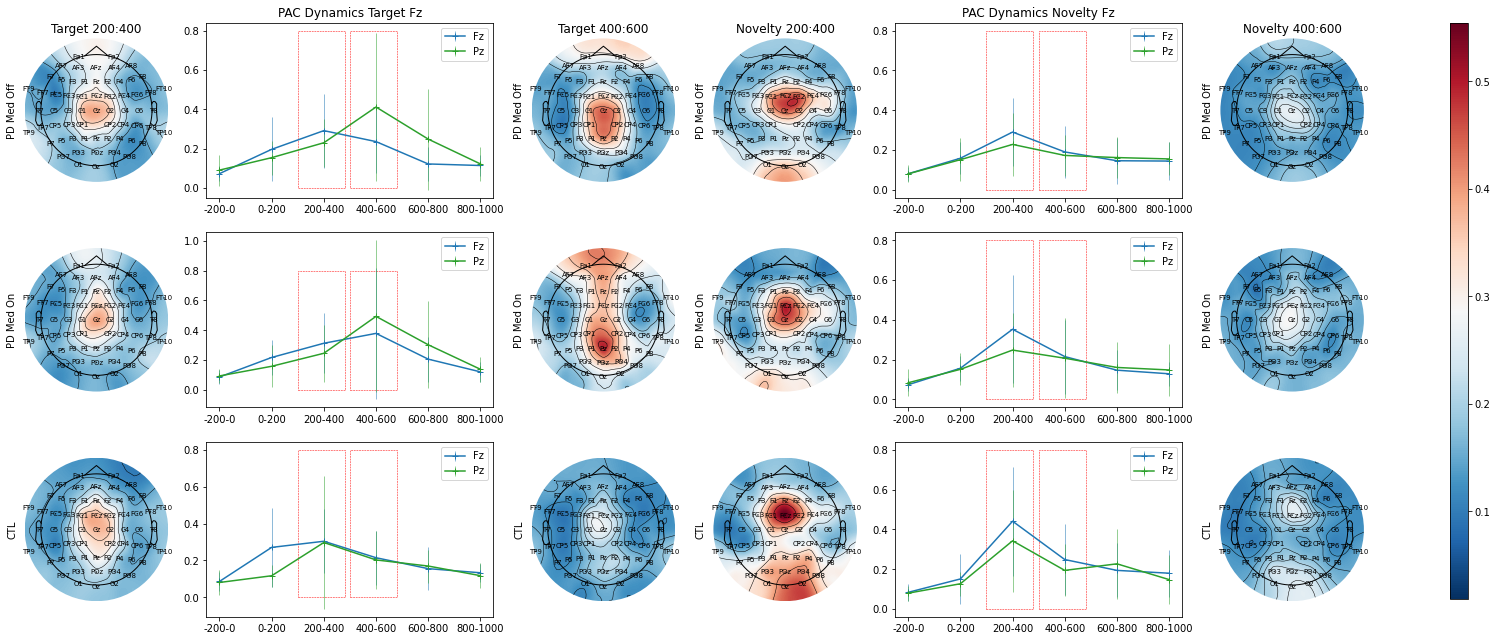

In [15]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 6, figsize=(24, 10), gridspec_kw={
                        'width_ratios': [1, 2, 1, 1, 2, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

# PAC Dynamics target Fz

for i in range(3):
    ['#1f77b4', '#ff7f0e', '#2ca02c']
    Fz = 1
    Pz = 12

    mvl_selected_Fz = mvl_time_filtered_mmap[i, :, 0, Fz, 8, 1, :].mean(
        axis=0) / 1e12
    std_Fz = mvl_time_filtered_mmap[i, :, 0, Fz, 8, 1, :].std(axis=0) / 1e12

    mvl_selected_Pz = mvl_time_filtered_mmap[i, :, 0, Pz, 8, 1, :].mean(
        axis=0) / 1e12
    std_Pz = mvl_time_filtered_mmap[i, :, 0, Pz, 8, 1, :].std(axis=0) / 1e12

    axs[i, 1].errorbar(times, mvl_selected_Fz, yerr=std_Fz, color='#1f77b4',
                       marker='+', label='Fz', elinewidth=0.5)
    axs[i, 1].errorbar(times, mvl_selected_Pz, yerr=std_Pz, color='#2ca02c',
                       marker='+', label='Pz', elinewidth=0.5)
#     axs[i, 4].plot(times, mvl_selected + std, 'g-.')
#     axs[i, 4].plot(times, mvl_selected - std, 'g-.')
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 1].add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 1].add_patch(rect)
    axs[i, 1].legend()

#     Fz = 1
#     Pz = 12
#     mvl_selected = mvl_time_filtered_mmap[i, :, 0, 1, 8, 1, :].mean(axis=0) / 1e12
#     std = mvl_time_filtered_mmap[i, :, 0, 1, 8, 1, :].std(axis=0) / 1e12
#     axs[i, 1].plot(times, mvl_selected)
#     axs[i, 1].plot(times, mvl_selected + std, 'g--')
#     axs[i, 1].plot(times, mvl_selected - std, 'g--')
#     rect = mpatches.Rectangle((1.5, 0), 0.9, 1, color='r', fill=False, lw=1, ls='--')
#     axs[i, 1].add_patch(rect)
#     rect = mpatches.Rectangle((2.5, 0), 0.9, 1, color='r', fill=False, lw=1, ls='--')
#     axs[i, 1].add_patch(rect)


# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


# Topo novelty 200:400
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 3]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


# PAC Dynamics novelty Fz
for i in range(3):
    ['#1f77b4', '#ff7f0e', '#2ca02c']
    Fz = 1
    Pz = 12

    mvl_selected_Fz = mvl_time_filtered_mmap[i, :, 2, Fz, 8, 1, :].mean(
        axis=0) / 1e12
    std_Fz = mvl_time_filtered_mmap[i, :, 2, Fz, 8, 1, :].std(axis=0) / 1e12

    mvl_selected_Pz = mvl_time_filtered_mmap[i, :, 2, Pz, 8, 1, :].mean(
        axis=0) / 1e12
    std_Pz = mvl_time_filtered_mmap[i, :, 2, Pz, 8, 1, :].std(axis=0) / 1e12

    axs[i, 4].errorbar(times, mvl_selected_Fz, yerr=std_Fz, color='#1f77b4',
                       marker='+', label='Fz', elinewidth=0.5)
    axs[i, 4].errorbar(times, mvl_selected_Pz, yerr=std_Pz, color='#2ca02c',
                       marker='+', label='Pz', elinewidth=0.5)
#     axs[i, 4].plot(times, mvl_selected + std, 'g-.')
#     axs[i, 4].plot(times, mvl_selected - std, 'g-.')
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 4].add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 4].add_patch(rect)
    axs[i, 4].legend()


# Topo novelty 400:600
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 5]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])
    axs[i, 3].set_ylabel(groups[i])
    axs[i, 5].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target Fz', 'Target 400:600',
          'Novelty 200:400', 'PAC Dynamics Novelty Fz', 'Novelty 400:600']
for i in range(6):
    axs[0, i].set_title(Titles[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)

cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.8])
clb = fig.colorbar(im, cax=cbar_ax)

#     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/dynamic_topography.svg')
plt.savefig('plots/dynamic_topography.png')
plt.show()


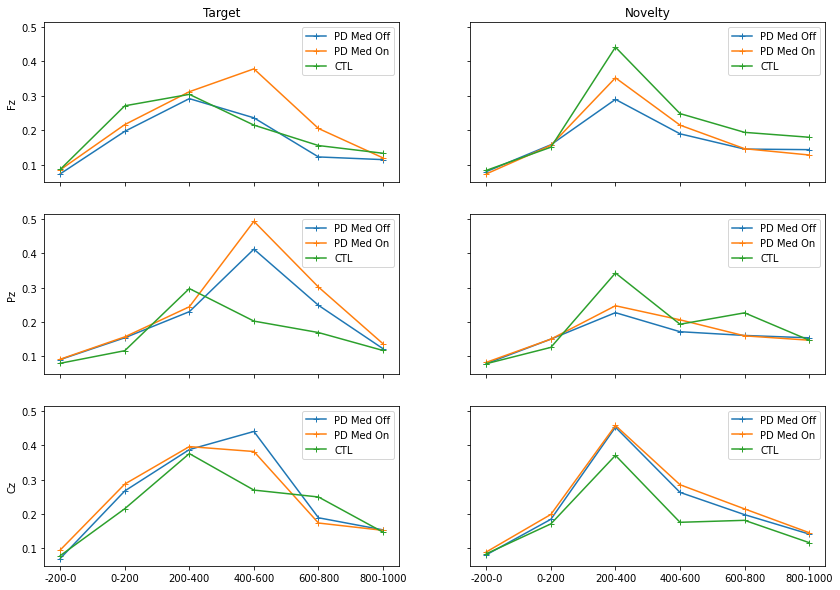

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(14, 10), sharex=True, sharey=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
Fz = 1
Pz = 12
Cz = 23
chs = [Fz, Pz, Cz]

for i, j, k in np.ndindex((3, 2, 3)):
    ax = axs[i, j]
    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          j*2, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, j*2, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, color=colors[k],
                marker='+', label=groups[k], elinewidth=0.5)
    ax.legend()

for i in range(3):
    axs[i, 0].set_ylabel(['Fz', 'Pz', 'Cz'][i])

for i in range(2):
    axs[0, i].set_title(['Target', 'Novelty'][i])

plt.show()


## dynamics plot

In [17]:
mvl_time_filtered_mmap.shape, mvl_selected.shape

((3, 25, 3, 63, 50, 12, 6), (6,))

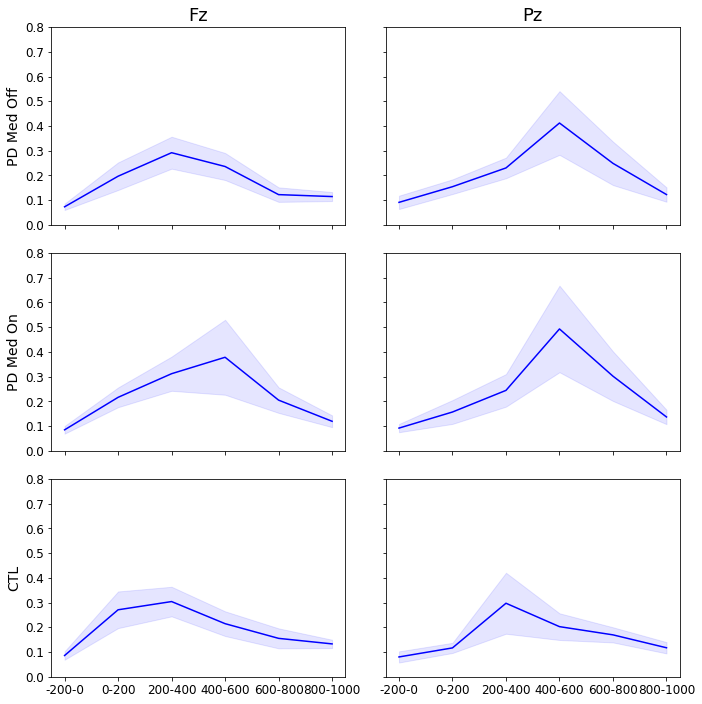

In [24]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
Fz = 1
Pz = 12
Cz = 23
chs = [Fz, Pz, ]

for i, j in np.ndindex((3, 2)):
    ax = axs[i, j]
    mvl_selected = mvl_time_filtered_mmap[i, :, 0, chs[j], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[i, :, 0, chs[j], 8, 1, :].std(axis=0) / 1e12

    Samples_num = 25 # mvl_selected.shape[0]
    # std /= np.sqrt(Samples_num)
    dof = Samples_num - 1
    confidence = 0.90
    t_crit = np.abs(scipy.stats.t.ppf((1-confidence)/2, dof))
    ci_1 = mvl_selected + t_crit * std/np.sqrt(Samples_num)
    ci_2 = mvl_selected - t_crit * std/np.sqrt(Samples_num)
    ax.plot(times, mvl_selected, color='b', label='mean')
    ax.fill_between(times, ci_2, ci_1, color='b', alpha=0.1)
    ax.set_ylim([0, 0.8])

    # ax.errorbar(times, mvl_selected, color=colors[k],
    #             marker='+', label=groups[k], elinewidth=0.5)
    # ax.legend()

for i in range(3):
    axs[i, 0].set_ylabel(groups[i], fontsize=14)
    axs[i, 0].yaxis.set_tick_params(labelsize=12)

for i in range(2):
    axs[0, i].set_title(['Fz', 'Pz', 'Cz'][i], fontsize=18)
    axs[-1, i].xaxis.set_tick_params(labelsize=12)

fig.tight_layout()

plt.savefig('plots/pac_dynamics_Fz_Pz.png')
plt.savefig('plots/pac_dynamics_Fz_Pz.svg')
plt.show()


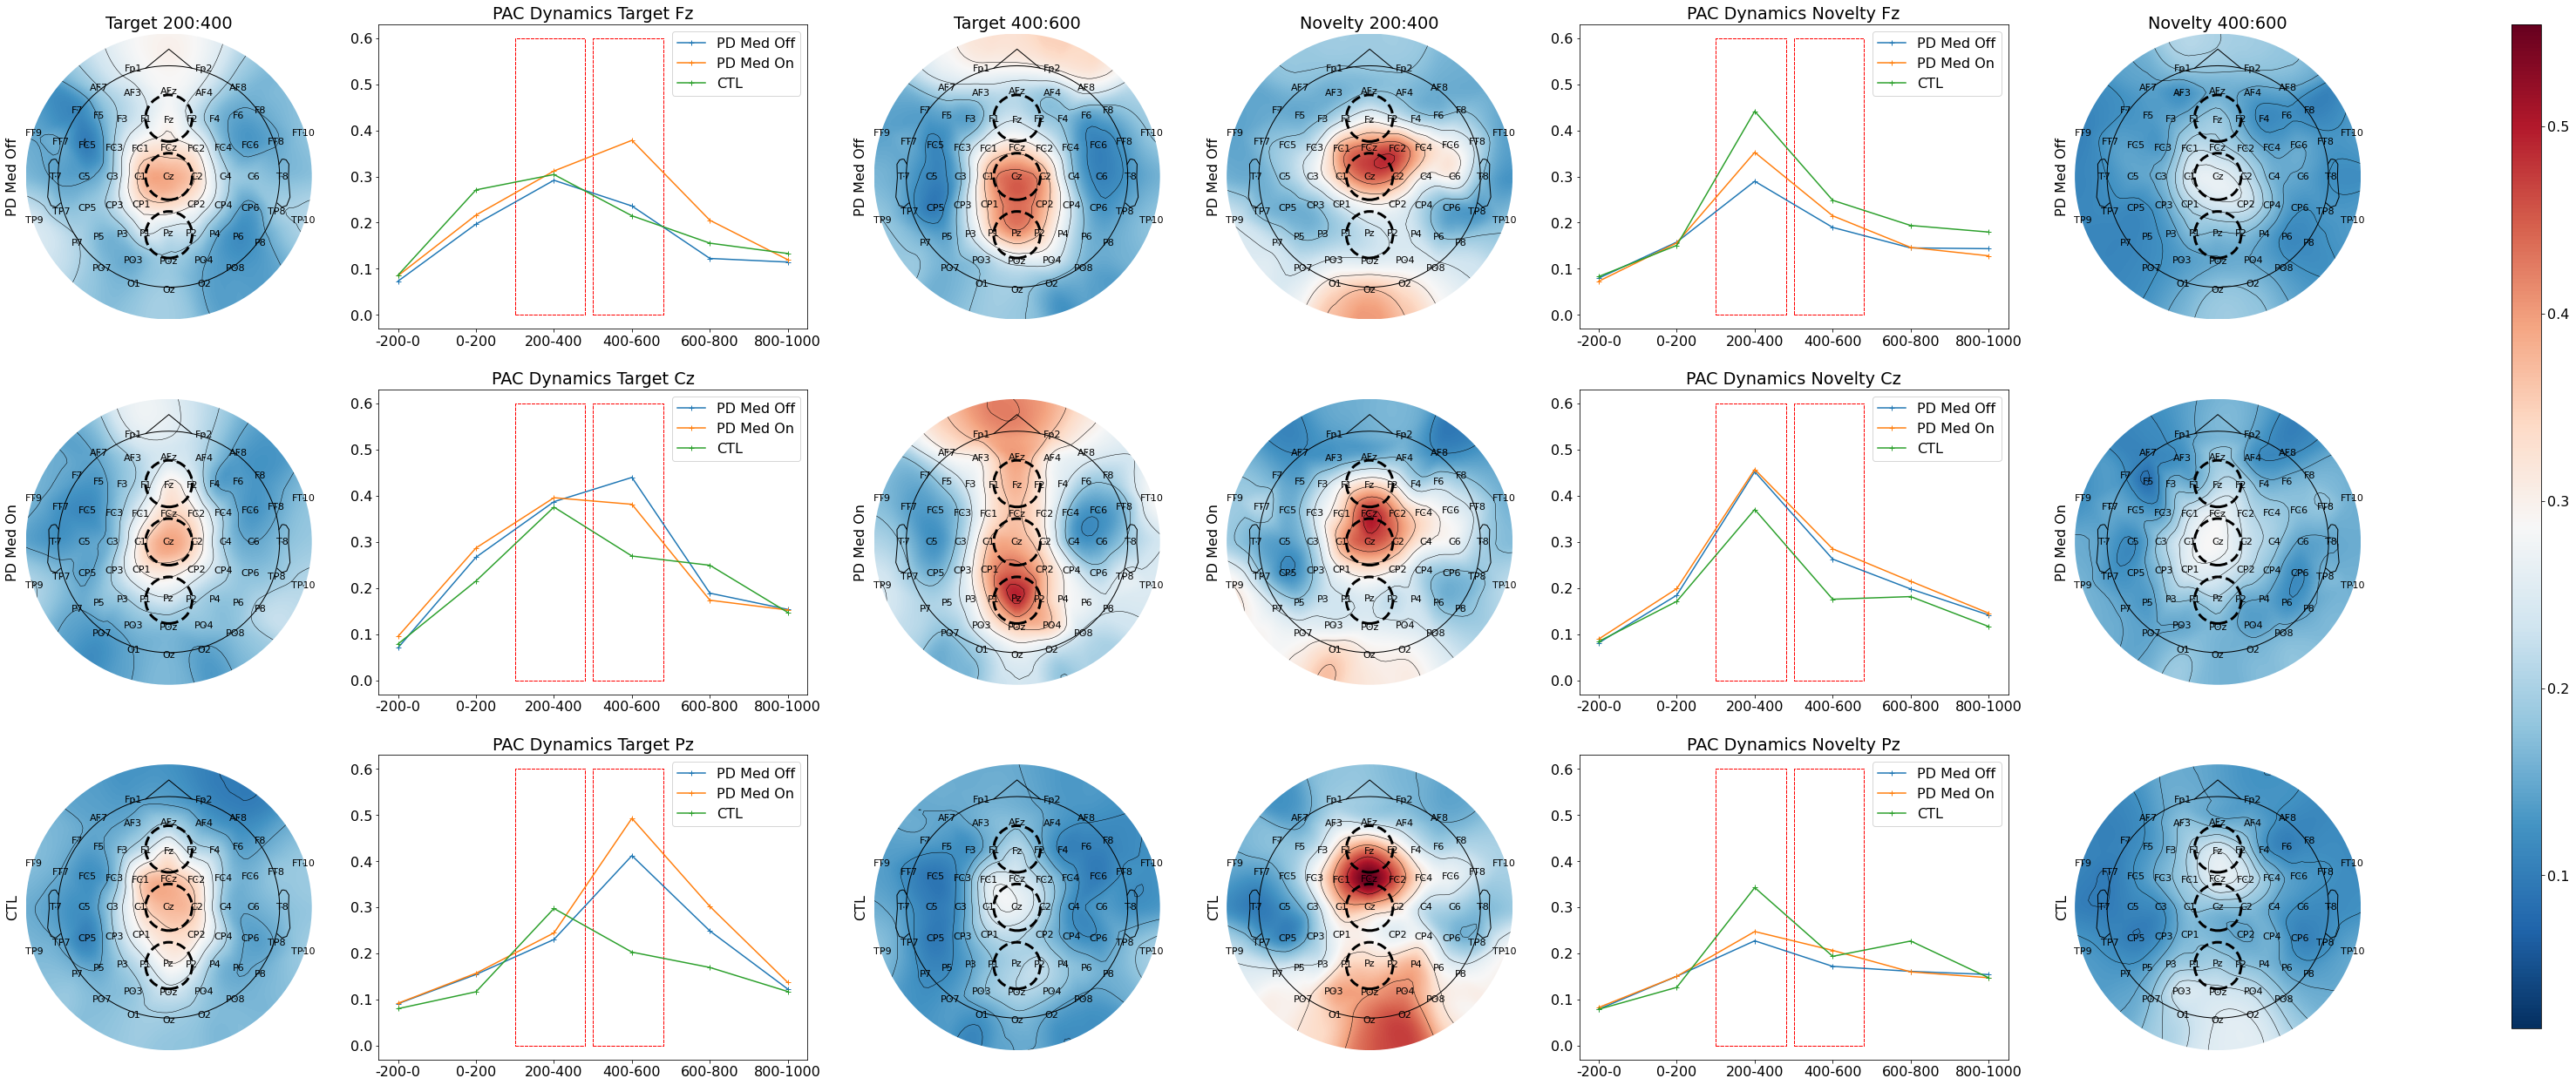

In [28]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 6, figsize=(48, 20), gridspec_kw={
                        'width_ratios': [1, 1.5, 1, 1, 1.5, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

circle_color = 'k'

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)

# PAC Dynamics target

for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 1]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          0, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 0, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=None, color=colors[k],
                marker='+', label=groups[k], elinewidth=0.5)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .6, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .6, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Target {ch_names[i]}')
    ax.legend()

# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


# Topo novelty 200:400
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 3]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


# PAC Dynamics novelty
for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 4]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          2, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 2, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=None, color=colors[k],
                marker='+', label=groups[k], elinewidth=0.5)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .6, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .6, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Novelty {ch_names[i]}')
    ax.legend()


# Topo novelty 400:600
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 5]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])
    axs[i, 3].set_ylabel(groups[i])
    axs[i, 5].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target Fz', 'Target 400:600',
          'Novelty 200:400', 'PAC Dynamics Novelty Fz', 'Novelty 400:600']
for i in range(6):
    axs[0, i].set_title(Titles[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)

cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.8])
clb = fig.colorbar(im, cax=cbar_ax)

#     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/dynamic_topography_channels.png')
plt.show()


In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, figsize=(24, 20), gridspec_kw={
                        'width_ratios': [1, 1.5, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

circle_color = 'k'

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)

# PAC Dynamics target

for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 1]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          0, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 0, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=None, color=colors[k],
                marker='+', label=groups[k], elinewidth=0.5)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .6, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .6, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Target {ch_names[i]}')
    ax.legend()

# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target Fz', 'Target 400:600',
          #   'Novelty 200:400', 'PAC Dynamics Novelty Fz', 'Novelty 400:600'
          ]
for i in range(3):
    axs[0, i].set_title(Titles[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)

cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)

#     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/dynamic_topography_channels_target.png')
plt.show()


In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, figsize=(18, 12), gridspec_kw={
                        'width_ratios': [1, 1.5, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

circle_color = 'k'

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    # circle = mpatches.Circle((0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    # ax.add_patch(circle)
    # circle = mpatches.Circle((0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    # ax.add_patch(circle)

# PAC Dynamics target

for i, k in np.ndindex(3, 1):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 1]

    mvl_selected = MVL_cross[i, :, 0, :, :, 32:35,
                             4:7, :].sum(axis=(3, 4)).mean(axis=0) / 1e12
    std = MVL_cross[i, :, 0, :, :, 32:35, 4:7, :].sum(
        axis=(3, 4)).std(axis=0) / 1e12

    chb, cha = selected_channels_pairs[k]
    # selected_channels.index(cha), selected_channels.index(chb)
    inda, indb = 6, 4
    mvl_selected = mvl_selected[inda, indb]
    std = std[inda, indb]

    # mvl_selected = mvl_time_filtered_mmap[i, :, 0, chs[k], 8, 1, :].mean(axis=0) / 1e12
    # std = mvl_time_filtered_mmap[i, :, 0, chs[k], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=None, color=colors[k],
                marker='+', label=groups[k], elinewidth=0.5)
    ax.plot(times, mvl_selected+std/2,  color=colors[k+2], linewidth=0.5)
    ax.plot(times, mvl_selected-std/2,  color=colors[k+2], linewidth=0.5)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .6, color='r', fill=False, lw=1, ls='--')
    # ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .6, color='r', fill=False, lw=1, ls='--')
    # ax.add_patch(rect)
    # ax.set_title(f'PAC Dynamics Target {ch_names[k]}')
    # ax.legend()

# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    # circle = mpatches.Circle((0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    # ax.add_patch(circle)
    # circle = mpatches.Circle((0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    # ax.add_patch(circle)


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])

Titles = ['Target 200:400',
          f'PAC Dynamics Target {cha}-{chb}', 'Target 400:600', ]
for i in range(3):
    axs[0, i].set_title(Titles[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)

#     axs[2, 1].set_xlabel(times[time])

plt.savefig(f'plots/dynamic_topography_{cha}-{chb}.png')
plt.show()

# cols = len(selected_channels_pairs)
# fig, axs = plt.subplots(1, cols, figsize=(
#     cols * 5, 4), sharex=True, sharey=True)
# times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# for i, j in np.ndindex((3, cols)):
#     if i != 1:
#         mvl_selected = MVL_cross[i, :, 0, :, :, 32:35,
#                                  4:7, :].sum(axis=(3, 4)).mean(axis=0) / 1e12
#         std = MVL_cross[i, :, 0, :, :, 32:35, 4:7, :].sum(
#             axis=(3, 4)).std(axis=0) / 1e12
#     else:
#         # The 6th person of PD Med on has only 63 event
#         sels = np.ones((25, ), dtype=bool)
#         sels[6] = False
#         mvl_selected = MVL_cross[i, sels, 0, :, :, 32:35, 4:7, :].sum(
#             axis=(3, 4)).mean(axis=0) / 1e12
#         std = MVL_cross[i, sels, 0, :, :, 32:35, 4:7, :].sum(
#             axis=(3, 4)).std(axis=0) / 1e12

#     ax = axs[j]
#     cha, chb = selected_channels_pairs[j]
#     inda, indb = selected_channels.index(cha), selected_channels.index(chb)

#     ax.errorbar(times, mvl_selected[inda, indb], yerr=std[inda, indb]/2,
#                 label=f'{groups[i]}', marker='+', capsize=6)
#     ax.legend()


# for i in range(cols):
#     axs[i].set_title(selected_channels_pairs[i])

# plt.savefig('plots/Cross_pac.svg')
# plt.savefig('plots/Cross_pac.png')


# plt.show()


In [ ]:
inda, indb


## Fz, Cz, Pz

In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 6, figsize=(48, 20), gridspec_kw={
                        'width_ratios': [1, 1.5, 1, 1, 1.5, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

circle_color = 'k'
plt.rcParams.update({'font.size': 16})


for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)

# PAC Dynamics target

for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 1]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          0, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 0, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=std/2, color=colors[k],
                marker='+', label=groups[k], elinewidth=1, capsize=6)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Target {ch_names[i]}')
    ax.legend()

# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


# Topo novelty 200:400
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 3]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


# PAC Dynamics novelty
for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 4]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          2, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 2, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=std/2, color=colors[k],
                marker='+', label=groups[k], elinewidth=1, capsize=6)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Novelty {ch_names[i]}')
    ax.legend()


# Topo novelty 400:600
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 5]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])
    axs[i, 3].set_ylabel(groups[i])
    axs[i, 5].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target Fz', 'Target 400:600',
          'Novelty 200:400', 'PAC Dynamics Novelty Fz', 'Novelty 400:600']
for i in range(6):
    axs[0, i].set_title(Titles[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)


cbar_ax = fig.add_axes([0.93, 0.127, 0.01, 0.8])
clb = fig.colorbar(im, cax=cbar_ax)

#     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/dynamic_topography_channels.png')
plt.savefig('plots/dynamic_topography_channels.svg')
plt.show()


## Stack plot

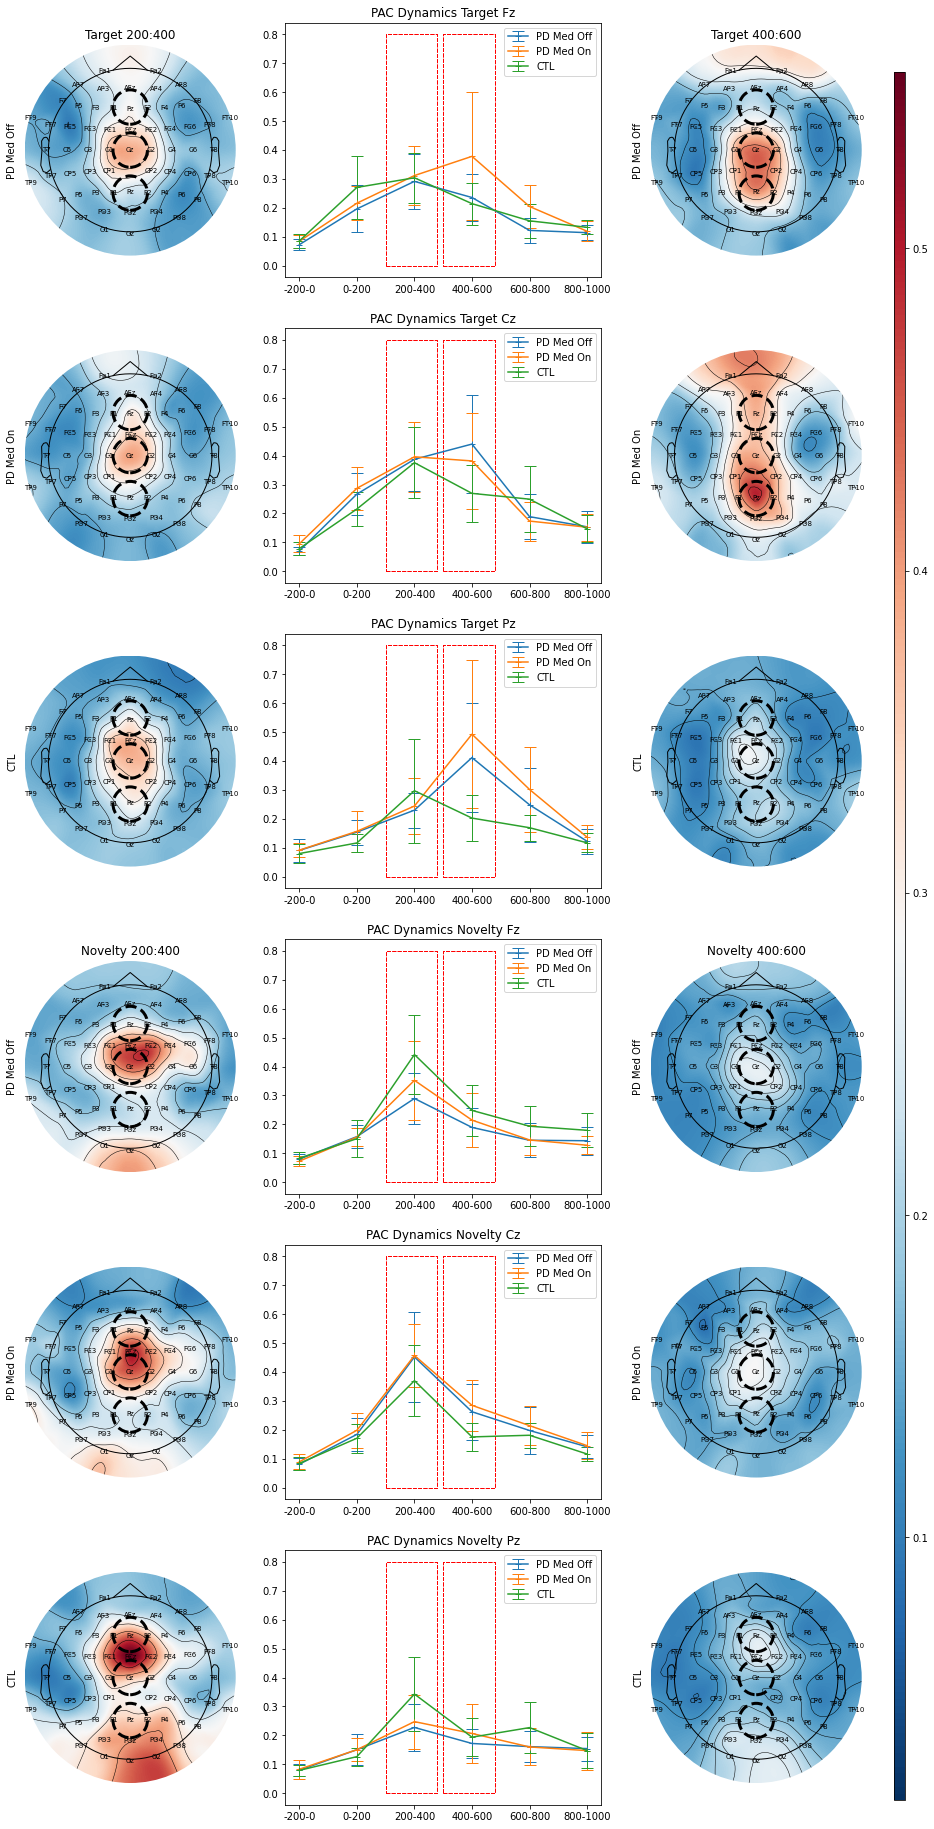

In [21]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(6, 3, figsize=(15, 30), gridspec_kw={
                        'width_ratios': [1, 1.5, 1, ]})
#                                                                               , 1, 1.5, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

circle_color = 'k'
# plt.rcParams.update({'font.size': 16})


for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)

# PAC Dynamics target

for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 1]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          0, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 0, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=std/2, color=colors[k],
                marker='+', label=groups[k], elinewidth=1, capsize=6)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Target {ch_names[i]}')
    ax.legend()

# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


# Topo novelty 200:400
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i + 3, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


# PAC Dynamics novelty
for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i + 3, 1]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          2, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 2, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=std/2, color=colors[k],
                marker='+', label=groups[k], elinewidth=1, capsize=6)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Novelty {ch_names[i]}')
    ax.legend()


# Topo novelty 400:600
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i + 3, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])
    axs[i+3, 0].set_ylabel(groups[i])
    axs[i+3, 2].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target Fz', 'Target 400:600',
          'Novelty 200:400', 'PAC Dynamics Novelty Fz', 'Novelty 400:600']
for i in range(6):
    axs[i//3 * 3, i % 3].set_title(Titles[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)


cbar_ax = fig.add_axes([0.93, 0.127, 0.01, 0.8])
clb = fig.colorbar(im, cax=cbar_ax)

#     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/dynamic_topography_channels_stack.png')
plt.savefig('plots/dynamic_topography_channels_stack.svg')
plt.show()


## 3\*3

In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, figsize=(15, 12), gridspec_kw={
                        'width_ratios': [1, 1.5, 1, ]})
#                                                                               , 1, 1.5, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

circle_color = 'k'
# plt.rcParams.update({'font.size': 16})


for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)

# PAC Dynamics target

for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 1]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          0, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 0, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=std/2, color=colors[k],
                marker='+', label=groups[k], elinewidth=1, capsize=6)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Target {ch_names[i]}')
    ax.legend()

# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)

for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target Fz', 'Target 400:600',
          'Novelty 200:400', 'PAC Dynamics Novelty Fz', 'Novelty 400:600']
for i in range(3):
    axs[i//3 * 3, i % 3].set_title(Titles[i])

cbar_ax = fig.add_axes([0.93, 0.127, 0.01, 0.8])
clb = fig.colorbar(im, cax=cbar_ax)

plt.savefig('plots/dynamic_topography_channels_Target.png')
plt.savefig('plots/dynamic_topography_channels_Target.svg')
plt.show()


montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, figsize=(15, 12), gridspec_kw={
                        'width_ratios': [1, 1.5, 1, ]})
#                                                                               , 1, 1.5, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo novelty 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

circle_color = 'k'
# plt.rcParams.update({'font.size': 16})


for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))
    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)


# PAC Dynamics novelty
for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 1]

    mvl_selected = mvl_time_filtered_mmap[k, :,
                                          2, chs[i], 8, 1, :].mean(axis=0) / 1e12
    std = mvl_time_filtered_mmap[k, :, 0, chs[i], 8, 1, :].std(axis=0) / 1e12

    ax.errorbar(times, mvl_selected, yerr=std/2, color=colors[k],
                marker='+', label=groups[k], elinewidth=1, capsize=6)
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
    ax.add_patch(rect)
    ax.set_title(f'PAC Dynamics Target {ch_names[i]}')
    ax.legend()

# Topo novelty 400:600
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

    circle = mpatches.Circle(
        (0, .05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, 0), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)
    circle = mpatches.Circle(
        (0, -.05), .02, color=circle_color, fill=False, ls='--', lw=3)
    ax.add_patch(circle)

for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target Fz', 'Target 400:600',
          'Novelty 200:400', 'PAC Dynamics Novelty Fz', 'Novelty 400:600']
for i in range(3):
    axs[i//3 * 3, i % 3].set_title(Titles[i+3])

cbar_ax = fig.add_axes([0.93, 0.127, 0.01, 0.8])
clb = fig.colorbar(im, cax=cbar_ax)


plt.savefig('plots/dynamic_topography_channels_Novelty.png')
plt.savefig('plots/dynamic_topography_channels_Novelty.svg')
plt.show()


## diff dynamic

NameError: name 'stats' is not defined

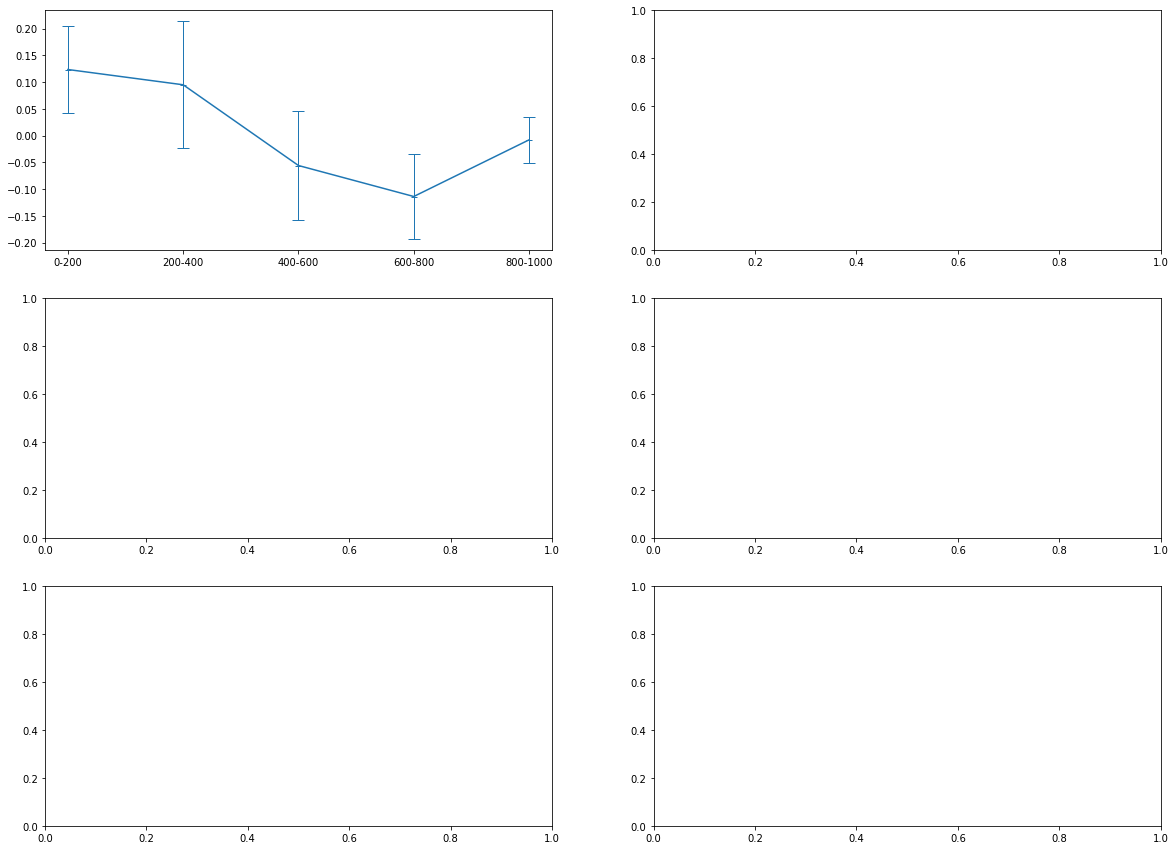

In [22]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 2, figsize=(
    20, 15), gridspec_kw={'width_ratios': [1, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 0]

    mvl_selected = np.diff(
        mvl_time_filtered_mmap[k, :, 0, chs[i], 8, 1, :]).mean(axis=0) / 1e12
    std = np.diff(mvl_time_filtered_mmap[k, :, 0, chs[i], 8, 1, :]).std(
        axis=0) / 1e12

    ax.errorbar(times[1:], mvl_selected, yerr=std/2, color=colors[k],
                marker='+', label=groups[k], elinewidth=1, capsize=6)
#     rect = mpatches.Rectangle((1.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
#     ax.add_patch(rect)
#     rect = mpatches.Rectangle((2.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
#     ax.add_patch(rect)
    t0, p0 = stats.ttest_ind(mvl_time_filtered_mmap[0, :, 0, chs[i], 8, 1, 2],
                             mvl_time_filtered_mmap[1, :, 0, chs[i], 8, 1, 2],)
    t1, p1 = stats.ttest_ind(mvl_time_filtered_mmap[0, :, 0, chs[i], 8, 1, 2],
                             mvl_time_filtered_mmap[2, :, 0, chs[i], 8, 1, 2],)
    t2, p2 = stats.ttest_ind(mvl_time_filtered_mmap[1, :, 0, chs[i], 8, 1, 2],
                             mvl_time_filtered_mmap[2, :, 0, chs[i], 8, 1, 2],)

    ax.set_title(f'{ch_names[i]}, {p0:0.2}, {p1:0.2}, {p2:0.2}')
    ax.set_ylim([-0.4, 0.4])
    ax.grid()
    ax.legend()


# PAC Dynamics novelty
for i, k in np.ndindex(3, 3):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, 1]

    mvl_selected = np.diff(
        mvl_time_filtered_mmap[k, :, 2, chs[i], 8, 1, :]).mean(axis=0) / 1e12
    std = np.diff(mvl_time_filtered_mmap[k, :, 2, chs[i], 8, 1, :]).std(
        axis=0) / 1e12

    ax.errorbar(times[1:], mvl_selected, yerr=std/2, color=colors[k],
                marker='+', label=groups[k], elinewidth=1, capsize=6)
#     rect = mpatches.Rectangle((1.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
#     ax.add_patch(rect)
#     rect = mpatches.Rectangle((2.5, 0), 0.9, 0.8, color='r', fill=False, lw=1, ls='--')
#     ax.add_patch(rect)
    t0, p0 = stats.ttest_ind(mvl_time_filtered_mmap[0, :, 2, chs[i], 8, 1, 2],
                             mvl_time_filtered_mmap[1, :, 2, chs[i], 8, 1, 2],)
    t1, p1 = stats.ttest_ind(mvl_time_filtered_mmap[0, :, 2, chs[i], 8, 1, 2],
                             mvl_time_filtered_mmap[2, :, 2, chs[i], 8, 1, 2],)
    t2, p2 = stats.ttest_ind(mvl_time_filtered_mmap[1, :, 2, chs[i], 8, 1, 2],
                             mvl_time_filtered_mmap[2, :, 2, chs[i], 8, 1, 2],)

    ax.set_title(f'{ch_names[i]}, {p0:.2}, {p1:.2}, {p2:.2}')
    ax.set_ylim([-0.4, 0.4])
    ax.grid()
    ax.legend()


plt.savefig('plots/diff_dynamic_topography_channels.png')
plt.savefig('plots/diff_dynamic_topography_channels.svg')
plt.show()


## Only Fz

In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 6, figsize=(24, 10), gridspec_kw={
                        'width_ratios': [1, 2, 1, 1, 2, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


# PAC Dynamics target Fz

for i in range(3):
    ['#1f77b4', '#ff7f0e', '#2ca02c']
    Fz = 1
    Pz = 12

    mvl_selected_Fz = mvl_time_filtered_mmap[i, :, 0, Fz, 8, 1, :].mean(
        axis=0) / 1e12
    std_Fz = mvl_time_filtered_mmap[i, :, 0, Fz, 8, 1, :].std(axis=0) / 1e12

    axs[i, 1].errorbar(times, mvl_selected_Fz, yerr=std_Fz, color='#1f77b4',
                       marker='+', label='Fz', elinewidth=0.5)
#     axs[i, 4].plot(times, mvl_selected + std, 'g-.')
#     axs[i, 4].plot(times, mvl_selected - std, 'g-.')
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 1].add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 1].add_patch(rect)
    axs[i, 1].legend()

#     Fz = 1
#     Pz = 12
#     mvl_selected = mvl_time_filtered_mmap[i, :, 0, 1, 8, 1, :].mean(axis=0) / 1e12
#     std = mvl_time_filtered_mmap[i, :, 0, 1, 8, 1, :].std(axis=0) / 1e12
#     axs[i, 1].plot(times, mvl_selected)
#     axs[i, 1].plot(times, mvl_selected + std, 'g--')
#     axs[i, 1].plot(times, mvl_selected - std, 'g--')
#     rect = mpatches.Rectangle((1.5, 0), 0.9, 1, color='r', fill=False, lw=1, ls='--')
#     axs[i, 1].add_patch(rect)
#     rect = mpatches.Rectangle((2.5, 0), 0.9, 1, color='r', fill=False, lw=1, ls='--')
#     axs[i, 1].add_patch(rect)


# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


# Topo novelty 200:400
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 3]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


# PAC Dynamics novelty Fz
for i in range(3):
    ['#1f77b4', '#ff7f0e', '#2ca02c']
    Fz = 1
    Pz = 12

    mvl_selected_Fz = mvl_time_filtered_mmap[i, :, 2, Fz, 8, 1, :].mean(
        axis=0) / 1e12
    std_Fz = mvl_time_filtered_mmap[i, :, 2, Fz, 8, 1, :].std(axis=0) / 1e12

    axs[i, 4].errorbar(times, mvl_selected_Fz, yerr=std_Fz, color='#1f77b4',
                       marker='+', label='Fz', elinewidth=0.5)
#     axs[i, 4].plot(times, mvl_selected + std, 'g-.')
#     axs[i, 4].plot(times, mvl_selected - std, 'g-.')
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 4].add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 4].add_patch(rect)
    axs[i, 4].legend()


# Topo novelty 400:600
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 5]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])
    axs[i, 2].set_ylabel(groups[i])
    axs[i, 3].set_ylabel(groups[i])
    axs[i, 5].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target', 'Target 400:600',
          'Novelty 200:400', 'PAC Dynamics Novelty', 'Novelty 400:600']
for i in range(6):
    axs[0, i].set_title(Titles[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)

    #     cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    #     clb = fig.colorbar(im, cax=cbar_ax)

    #     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/dynamic_topography_Fz.svg')
plt.show()


## Only Pz

In [ ]:
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 6, figsize=(24, 10), gridspec_kw={
                        'width_ratios': [1, 2, 1, 1, 2, 1]})

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# Topo target 200:400

vmin = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).min() / 1e12
vmax = mvl_time_filtered_mmap[:, :, :, :,
                              8, 1, (2, 3)].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 0]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


# PAC Dynamics target Pz

for i in range(3):
    ['#1f77b4', '#ff7f0e', '#2ca02c']
    Fz = 1
    Pz = 12

    mvl_selected_Pz = mvl_time_filtered_mmap[i, :, 0, Pz, 8, 1, :].mean(
        axis=0) / 1e12
    std_Pz = mvl_time_filtered_mmap[i, :, 0, Pz, 8, 1, :].std(axis=0) / 1e12

    axs[i, 1].errorbar(times, mvl_selected_Pz, yerr=std_Pz, color='#2ca02c',
                       marker='+', label='Pz', elinewidth=0.5)
#     axs[i, 4].plot(times, mvl_selected + std, 'g-.')
#     axs[i, 4].plot(times, mvl_selected - std, 'g-.')
    rect = mpatches.Rectangle(
        (1.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 1].add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), 0.9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 1].add_patch(rect)
    axs[i, 1].legend()

#     Fz = 1
#     Pz = 12
#     mvl_selected = mvl_time_filtered_mmap[i, :, 0, 1, 8, 1, :].mean(axis=0) / 1e12
#     std = mvl_time_filtered_mmap[i, :, 0, 1, 8, 1, :].std(axis=0) / 1e12
#     axs[i, 1].plot(times, mvl_selected)
#     axs[i, 1].plot(times, mvl_selected + std, 'g--')
#     axs[i, 1].plot(times, mvl_selected - std, 'g--')
#     rect = mpatches.Rectangle((1.5, 0), 0.9, 1, color='r', fill=False, lw=1, ls='--')
#     axs[i, 1].add_patch(rect)
#     rect = mpatches.Rectangle((2.5, 0), 0.9, 1, color='r', fill=False, lw=1, ls='--')
#     axs[i, 1].add_patch(rect)


# Topo target 400:600

# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 0, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 2]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


# Topo novelty 200:400
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 2].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 2].mean(axis=0) / 1e12
    ax = axs[i, 3]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


# PAC Dynamics novelty Pz
for i in range(3):
    ['#1f77b4', '#ff7f0e', '#2ca02c']
    Fz = 1
    Pz = 12

    mvl_selected_Pz = mvl_time_filtered_mmap[i, :, 2, Pz, 8, 1, :].mean(
        axis=0) / 1e12
    std_Pz = mvl_time_filtered_mmap[i, :, 2, Pz, 8, 1, :].std(axis=0) / 1e12

    axs[i, 4].errorbar(times, mvl_selected_Pz, yerr=std_Pz, color='#2ca02c',
                       marker='+', label='Pz', elinewidth=0.5)
#     axs[i, 4].plot(times, mvl_selected + std, 'g-.')
#     axs[i, 4].plot(times, mvl_selected - std, 'g-.')
    rect = mpatches.Rectangle(
        (1.5, 0), .9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 4].add_patch(rect)
    rect = mpatches.Rectangle(
        (2.5, 0), .9, .8, color='r', fill=False, lw=0.5, ls='--')
    axs[i, 4].add_patch(rect)
    axs[i, 4].legend()


# Topo novelty 400:600
# vmin = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).min() / 1e12
# vmax = mvl_time_filtered_mmap[:, :, :, :, 8, 1, 3].mean(axis=1).max() / 1e12

for i in range(3):
    mvl_selected = mvl_time_filtered_mmap[i,
                                          :, 2, :, 8, 1, 3].mean(axis=0) / 1e12
    ax = axs[i, 5]
    data = mvl_selected.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=ax, show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])

Titles = ['Target 200:400', 'PAC Dynamics Target Pz', 'Target 400:600',
          'Novelty 200:400', 'PAC Dynamics Novelty Pz', 'Novelty 400:600']
for i in range(6):
    axs[0, i].set_title(Titles[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)

    #     cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    #     clb = fig.colorbar(im, cax=cbar_ax)

    #     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/dynamic_topography_Pz.svg')
plt.show()


# Cross Channel

## total

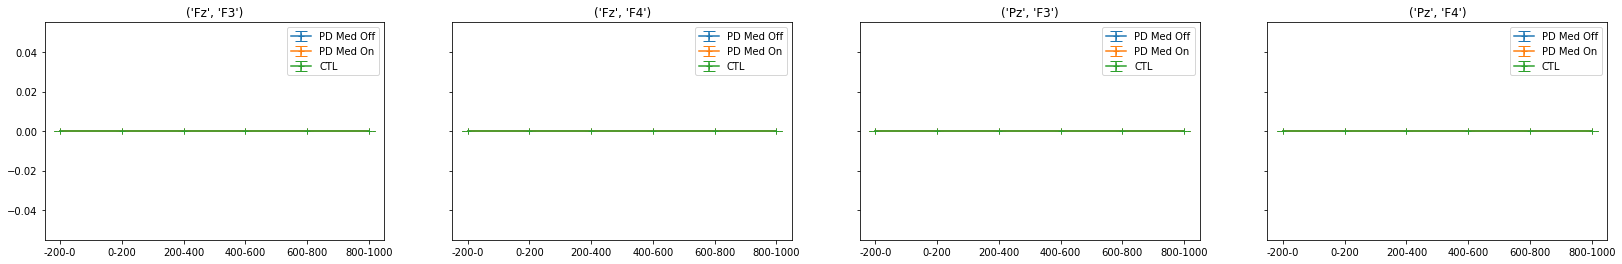

In [14]:
cols = len(selected_channels_pairs)
fig, axs = plt.subplots(1, cols, figsize=(
    cols * 7, 4), sharex=True, sharey=True)
times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

for i, j in np.ndindex((3, cols)):
    if i != 1:
        mvl_selected = MVL_cross[i, :, 0, :, :, 32:35,
                                 4:7, :].sum(axis=(3, 4)).mean(axis=0) / 1e12 / 16
        std = MVL_cross[i, :, 0, :, :, 32:35, 4:7, :].sum(
            axis=(3, 4)).std(axis=0) / 1e12 / 16
    else:
        # The 6th person of PD Med on has only 63 event
        sels = np.ones((25, ), dtype=bool)
        sels[6] = False
        mvl_selected = MVL_cross[i, sels, 0, :, :, 32:35, 4:7, :].sum(
            axis=(3, 4)).mean(axis=0) / 1e12 / 16
        std = MVL_cross[i, sels, 0, :, :, 32:35, 4:7, :].sum(
            axis=(3, 4)).std(axis=0) / 1e12 / 16

    ax = axs[j]
    cha, chb = selected_channels_pairs[j]
    inda, indb = selected_channels_corss.index(
        cha), selected_channels_corss.index(chb)

    ax.errorbar(times, mvl_selected[inda, indb], yerr=std[inda, indb]/2,
                label=f'{groups[i]}', marker='+', capsize=6)
    ax.legend()


for i in range(cols):
    axs[i].set_title(selected_channels_pairs[i])

plt.savefig('plots/Cross_pac.svg')
plt.savefig('plots/Cross_pac.png')


plt.show()


## Two Blocks

In [ ]:
selected_events = ['S200', 'S201', 'S202']
selected_channels_corss_2block = ['F3', 'F4', 'FC3', 'FC4', 'Fz', 'Pz', 'Cz']

selected_channels_pairs = [
    ('Fz', 'FC3'), ('Fz', 'FC4'),
    ('Pz', 'FC3'), ('Pz', 'FC4'),
    # ('Cz', 'FC3'), ('Cz', 'FC4'),

    # ('Fz', 'F3'), ('Fz', 'F4'),
    # ('Pz', 'F3'), ('Pz', 'F4'),
    # ('Cz', 'F3'), ('Cz', 'F4'),

    # ('Cz', 'Fz'), ('Cz', 'Pz'),
    # ('Pz', 'Cz'), ('Fz', 'Cz'),
    # ('Pz', 'Fz'),
    # ('Fz', 'Pz'),
]

gamma = [33, 36]
beta = [5, 8]

mvl_cross_time_mmap_path = os.path.join(
    ds_path, f'MVL_cross_time_{"_33_36_double_2run_cz"}.mmap')

mvl_cross_time = np.memmap(mvl_cross_time_mmap_path, dtype=float,
                           shape=(3,  # pd_drug_type
                                  25,  # Subjects
                                  6,  # event_types
                                  # Selected Channels
                                  len(selected_channels_corss_2block),
                                  # Selected Channels
                                  len(selected_channels_corss_2block),
                                  gamma[1] - gamma[0] + 1,  # High Freq
                                  beta[1] - beta[0] + 1,  # Low Freq
                                  6
                                  ))

mx = mvl_cross_time.max()
nrm = np.linalg.norm(mvl_cross_time)
zrs = np.sum(mvl_cross_time == 0)

print(mx, nrm, zrs, mvl_cross_time.shape)


4.092524940020433 368.78232265269287 14112 (3, 25, 6, 7, 7, 4, 4, 6)


In [ ]:
# for i, sub in np.ndindex((3, 25)):
#     print(i, sub, np.where(mvl_cross_time[i, sub]==0)[0])

(mvl_cross_time[1, 6, 5] == 0).sum()


4704

In [ ]:
i = 0
mvl_selected_1 = mvl_cross_time[i, :, 0, :,
                                :, :, :, :].sum(axis=(3, 4)).mean(axis=0)
mvl_selected_1.shape


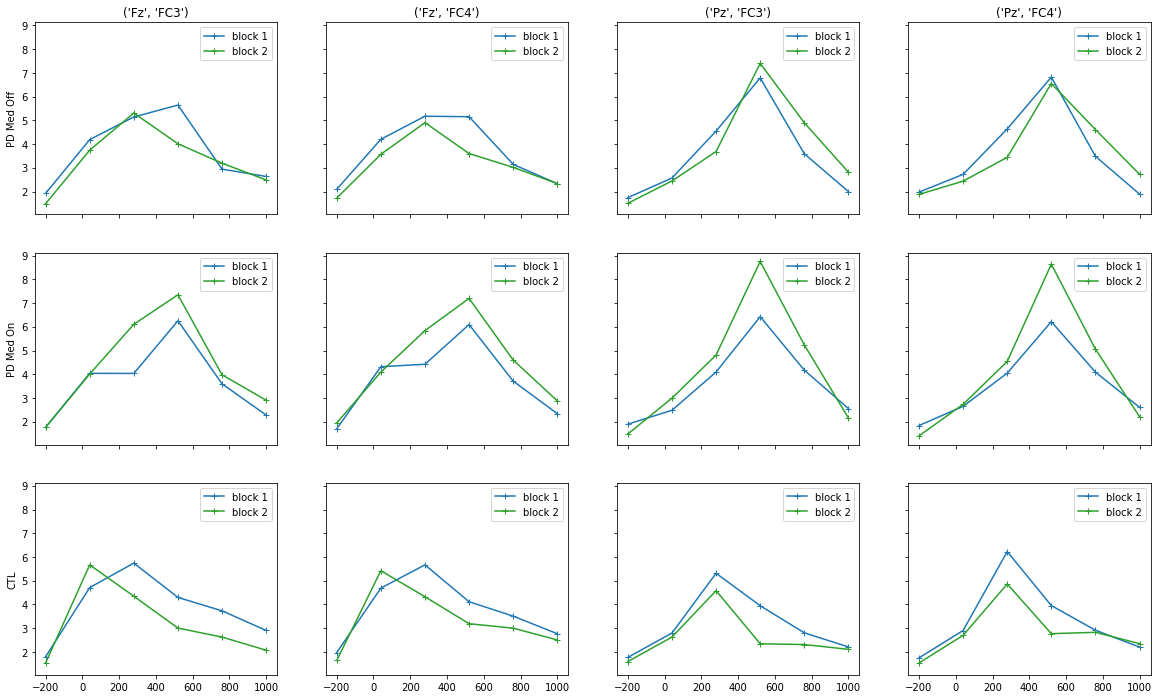

In [ ]:
cols = len(selected_channels_pairs)
fig, axs = plt.subplots(3, cols, figsize=(20, 12), sharex=True, sharey=True)

for i, j in np.ndindex((3, cols)):
    sels = np.ones((25, ), dtype=bool)
    if i == 1:
        sels[6] = False
    mvl_selected_1 = mvl_cross_time[i, sels, 0, :, :, :, :, :].sum(
        axis=(3, 4)).mean(axis=0)
    mvl_selected_2 = mvl_cross_time[i, sels, 1, :, :, :, :, :].sum(
        axis=(3, 4)).mean(axis=0)
    std1 = mvl_cross_time[i, sels, 0, :, :,
                          :, :, :].sum(axis=(3, 4)).std(axis=0)
    std2 = mvl_cross_time[i, sels, 1, :, :,
                          :, :, :].sum(axis=(3, 4)).std(axis=0)

    ax = axs[i, j]
    cha, chb = selected_channels_pairs[j]
    inda, indb = selected_channels_corss_2block.index(
        cha), selected_channels_corss_2block.index(chb)

#     ax.errorbar(times, y=mvl_selected_1[inda, indb], yerr=std1[inda, indb], label='block 1', elinewidth=0.5)
#     ax.errorbar(times, y=mvl_selected_2[inda, indb], yerr=std2[inda, indb], label='block 2', elinewidth=0.5)

    old_times = np.linspace(-200, 1000, num=6, endpoint=True)
    new_times = np.linspace(-200, 1000, num=101, endpoint=True)
    # f = interp1d(old_times, mvl_selected_1[inda, indb], kind='cubic')
    # f2 = interp1d(old_times, mvl_selected_2[inda, indb], kind='cubic')

    ax.plot(old_times, mvl_selected_1[inda, indb], label='block 1', marker='+')
    ax.plot(old_times, mvl_selected_2[inda, indb],
            label='block 2', marker='+', c='#2ca02c')
    # ax.plot(new_times, f(new_times), label='block 1 cubic')
    # ax.plot(new_times, f2(new_times), label='block 2 cubic')

    ax.legend()


for i in range(3):
    axs[i, 0].set_ylabel(groups[i])

for i in range(cols):
    axs[0, i].set_title(selected_channels_pairs[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)

    #     cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    #     clb = fig.colorbar(im, cax=cbar_ax)

    #     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/2blocks_pac_4channels.svg')
plt.show()


## T-Test

$t^p_{Pz3,ctl} < t^p_{Pz3,ON}$

$t^p_{Pz3,ctl} < t^p_{Pz3,Off}$

$t^p_{Fz3,off} < t^p_{Fz3,ON}$ pair

$t^p_{Fz3,ctl} < t^p_{Fz3,ON}$ 



$t^{p1}_{Fz3,ctl} > t^{p2}_{Fz3,ctl}$ pair

$t^{p1}_{Fz3,off} > t^{p2}_{Fz3,off}$ pair


$\delta t_{Fz3,off} < \delta t_{Fz3,ON}$ 

$\delta t_{Fz3,ctl} < \delta t_{Fz3,ON}$ 

$\delta t_{Fz3,ctl} < \delta t_{Fz3,off}$ 


In [ ]:
def tp(arr):
    old_times = np.linspace(-200, 800, num=6, endpoint=True)
    new_times = np.linspace(-200, 800, num=501, endpoint=True)
    f = interp1d(old_times, arr, kind='cubic')
    res = new_times[f(new_times).argmax(axis=-1)]

    # plt.plot(old_times, mvl_selected_1[inda, indb])
    # plt.plot(new_times, f(new_times))
    # plt.plot(res, f(res), 'o')
    # plt.title(res)
    # plt.show()

    return res


tp(mvl_selected_1[inda, indb])


In [ ]:
MVL_cross.shape


In [ ]:
selected_channels_corss = ['FC3', 'FC4', 'AF3',
                           'AF4', 'F3', 'F4', 'Fz', 'Pz', 'Cz', 'FCz']
tps = tp(MVL_cross.sum(axis=(5, 6)))
tps.shape


In [ ]:
print('PZ F3')
print(scipy.stats.ttest_ind(tps[2, :, 0, 7, 4],
                            tps[1, :, 0, 7, 4])[1])
print(scipy.stats.ttest_ind(tps[2, :, 0, 7, 4],
                            tps[0, :, 0, 7, 4])[1])
print()
print('PZ F4')
print(scipy.stats.ttest_ind(tps[2, :, 0, 7, 5],
                            tps[1, :, 0, 7, 5])[1])
print(scipy.stats.ttest_ind(tps[2, :, 0, 7, 5],
                            tps[0, :, 0, 7, 5])[1])
print()
print('F3 PZ')
print(scipy.stats.ttest_ind(tps[2, :, 0, 4, 7],
                            tps[1, :, 0, 4, 7])[1])
print(scipy.stats.ttest_ind(tps[2, :, 0, 4, 7],
                            tps[0, :, 0, 4, 7])[1])
print()
print()

print('FZ F3')
print(scipy.stats.ttest_rel(tps[0, :, 0, 6, 4],
                            tps[1, :, 0, 6, 4])[1])
print(scipy.stats.ttest_ind(tps[2, :, 0, 6, 4],
                            tps[1, :, 0, 6, 4])[1])
print()
print('F3 FZ')
print(scipy.stats.ttest_rel(tps[0, :, 0, 4, 6],
                            tps[1, :, 0, 4, 6])[1])
print(scipy.stats.ttest_ind(tps[2, :, 0, 4, 6],
                            tps[1, :, 0, 4, 6])[1])


In [ ]:
selected_channels_corss_2block = ['F3', 'F4', 'FC3', 'FC4', 'Fz', 'Pz', 'Cz']
selected_channels_pairs = [
    ('Fz', 'FC3'), ('Fz', 'FC4'),
    ('Pz', 'FC3'), ('Pz', 'FC4'),
    # ('Cz', 'FC3'), ('Cz', 'FC4'),

    ('Fz', 'F3'), ('Fz', 'F4'),
    ('Pz', 'F3'), ('Pz', 'F4'),
    # ('Cz', 'F3'), ('Cz', 'F4'),

    # ('Cz', 'Fz'), ('Cz', 'Pz'),
    # ('Pz', 'Cz'), ('Fz', 'Cz'),
    # ('Pz', 'Fz'),
    # ('Fz', 'Pz'),
]

tps2b = np.zeros((3, 25, 2, 7, 7))

for i, j in np.ndindex((3, cols)):
    if i != 1:
        mvl_selected_1 = mvl_cross_time[i, :,
                                        0, :, :, :, :, :].sum(axis=(3, 4))
        mvl_selected_2 = mvl_cross_time[i, :,
                                        1, :, :, :, :, :].sum(axis=(3, 4))
        std1 = mvl_cross_time[i, :, 0, :, :, :,
                              :, :].sum(axis=(3, 4)).std(axis=0)
        std2 = mvl_cross_time[i, :, 1, :, :, :,
                              :, :].sum(axis=(3, 4)).std(axis=0)
    else:
        # The 6th person of PD Med on has only 63 event
        sels = np.ones((25, ), dtype=bool)
        sels[6] = False
        mvl_selected_1 = mvl_cross_time[i, sels,
                                        0, :, :, :, :, :].sum(axis=(3, 4))
        mvl_selected_2 = mvl_cross_time[i, sels,
                                        1, :, :, :, :, :].sum(axis=(3, 4))
        std1 = mvl_cross_time[i, sels, 0, :, :,
                              :, :, :].sum(axis=(3, 4)).std(axis=0)
        std2 = mvl_cross_time[i, sels, 1, :, :,
                              :, :, :].sum(axis=(3, 4)).std(axis=0)

    # ax = axs[i, j]
    cha, chb = selected_channels_pairs[j]
    inda, indb = selected_channels_corss_2block.index(
        cha), selected_channels_corss_2block.index(chb)

    tps2b[i, :mvl_selected_1.shape[0], 0] = tp(mvl_selected_1)
    tps2b[i, :mvl_selected_2.shape[0], 1] = tp(mvl_selected_2)
    if mvl_selected_1.shape[0] < 25:
        tps2b[i, -1, 0] = tps2b[i, :-1, 0].mean(axis=0)
        tps2b[i, -1, 1] = tps2b[i, :-1, 1].mean(axis=0)


NameError: name 'tp' is not defined

In [ ]:
print('FZ F3')
print(scipy.stats.ttest_rel(tps2b[2, :, 0, 4, 0],
                            tps2b[2, :, 1, 4, 0])[1])
print(scipy.stats.ttest_rel(tps2b[0, :, 0, 4, 0],
                            tps2b[0, :, 1, 4, 0])[1])
print()
print('delta FZ F3')
print(scipy.stats.ttest_rel(tps2b[2, :, 0, 4, 0] - tps2b[2, :, 1, 4, 0],
                            tps2b[1, :, 0, 4, 0] - tps2b[1, :, 1, 4, 0], )[1])
print(scipy.stats.ttest_ind(tps2b[0, :, 0, 4, 0] - tps2b[0, :, 1, 4, 0],
                            tps2b[1, :, 0, 4, 0] - tps2b[1, :, 1, 4, 0], )[1])
print(scipy.stats.ttest_ind(tps2b[2, :, 0, 4, 0] - tps2b[2, :, 1, 4, 0],
                            tps2b[0, :, 0, 4, 0] - tps2b[0, :, 1, 4, 0], )[1])


## box plot

In [ ]:
plt.boxplot(tps[:, :, 0, 7, 4].T)
plt.show()


In [ ]:
plt.boxplot(tps[:, :, 0, 4, 7].T)
plt.show()


In [ ]:
old_times = np.linspace(-100, 900, num=6, endpoint=True)
new_times = np.linspace(-100, 900, num=501, endpoint=True)
ind = np.zeros((7, 7))
for i, j in np.ndindex(7, 7):
    f2 = interp1d(old_times, mvl_selected_1[i, j], kind='cubic')
    ind[i, j] = f2(new_times).argmax(axis=-1)
# f(new_times)[0, 0] - f2(new_times)
ind == f(new_times).argmax(axis=-1)


In [ ]:
run2 = mvl_cross_time[0, :, , :, :, :, :, :].sum(axis=(3, 4))
(run2 == 0).sum()


In [ ]:
len(selected_channels_pairs)


# Pairwise diff

In [13]:
mvl_2ds_filtered.shape, mvl_time_filtered_mmap.shape, #mvl_selected_freq.shape


((3, 25, 3, 63, 50, 12), (3, 25, 3, 63, 50, 12, 6))

-0.56


(array([3., 0., 4., 0., 6., 0., 0., 6., 0., 3., 0., 3.]),
 array([-3.        , -2.58333333, -2.16666667, -1.75      , -1.33333333,
        -0.91666667, -0.5       , -0.08333333,  0.33333333,  0.75      ,
         1.16666667,  1.58333333,  2.        ]),
 <BarContainer object of 12 artists>)

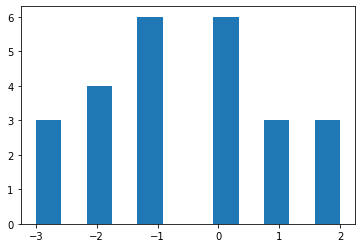

In [20]:
Fz = 1
# Pz = 
a, b = mvl_time_filtered_mmap[0, :, 0, Fz, 8, 1, :], mvl_time_filtered_mmap[1, :, 0, Fz, 8, 1, :]
a2, b2 = a.argmax(axis=-1), b.argmax(axis=-1)
print((a2-b2).mean())
plt.hist(a2-b2, bins=12)
# plt.show()

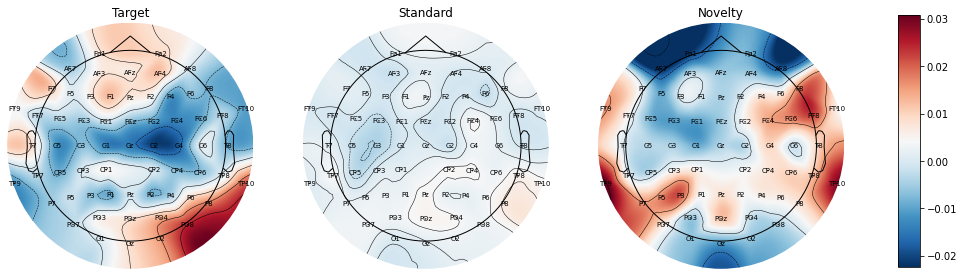

In [ ]:
mvl_selected_freq = mvl_2ds_filtered[:, :, :, :, 8, 1] / 1e12
delta_mvl = (mvl_selected_freq[1] - mvl_selected_freq[0]).mean(axis=0)

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
vmin = delta_mvl.min()
vmax = delta_mvl.max()
for i in range(3):
    data = delta_mvl[i].reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=axs[i], show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

for i in range(3):
    # axs[i, 0].set_ylabel(groups[i])
    axs[i].set_title(event_types[i])

    axs[i].xaxis.set_visible(True)
    axs[i].yaxis.set_visible(True)


cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)

plt.savefig('plots/topographic_diff.png')
plt.savefig('plots/topographic_diff.svg')
plt.show()


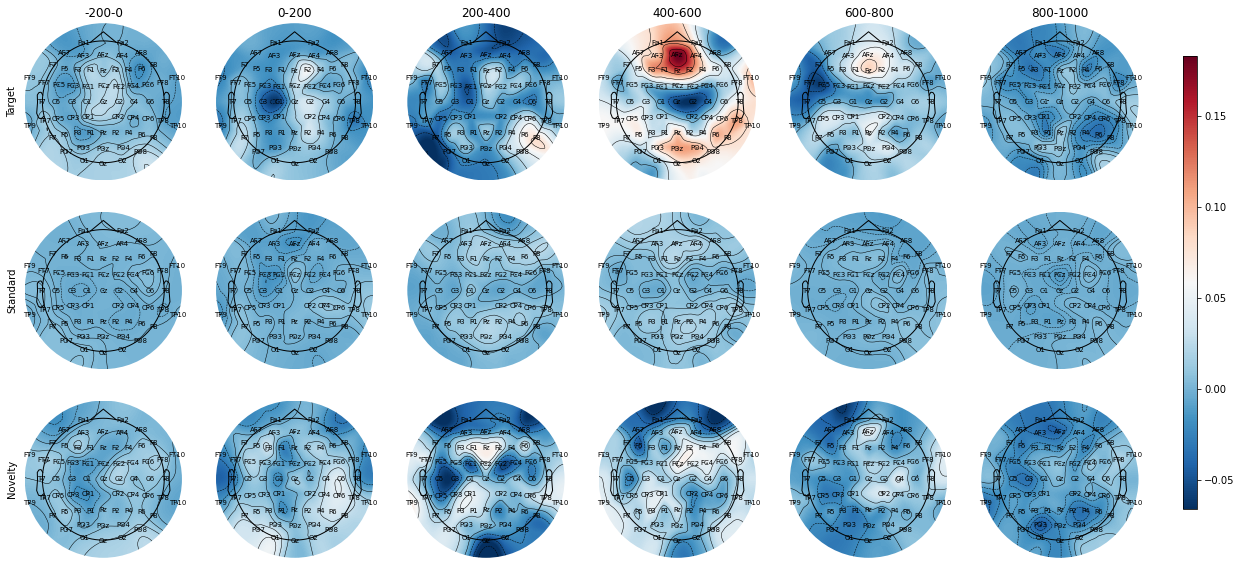

In [ ]:

mvl_selected_freq_time = mvl_time_filtered_mmap[:, :, :, :, 8, 1] / 1e12
delta_mvl_time = (
    mvl_selected_freq_time[1] - mvl_selected_freq_time[0]).mean(axis=0)

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
mne_info = mne.create_info(ch_names=selected_channels,
                           sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(20, 9))
vmin = delta_mvl_time.min()
vmax = delta_mvl_time.max()
# vabs = max(abs(vmin), abs(vmax))
# vmin, vmax = -vabs, vabs
# norm = DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)

for i, j in np.ndindex((3, 6)):
    data = delta_mvl_time[i, :, j].reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0],
                                  mvl_evoked.info, axes=axs[i, j], show=False,
                                  names=selected_channels, cmap='RdBu_r',
                                  vlim=(vmin, vmax))

for i, j in np.ndindex((3, 6)):
    axs[i, 0].set_ylabel(event_types[i])
    axs[0, j].set_title(times[j])

    axs[i, j].xaxis.set_visible(True)
    axs[i, j].yaxis.set_visible(True)


cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)

plt.savefig('plots/topographic_diff_time.png')
plt.savefig('plots/topographic_diff_time.svg')
plt.show()


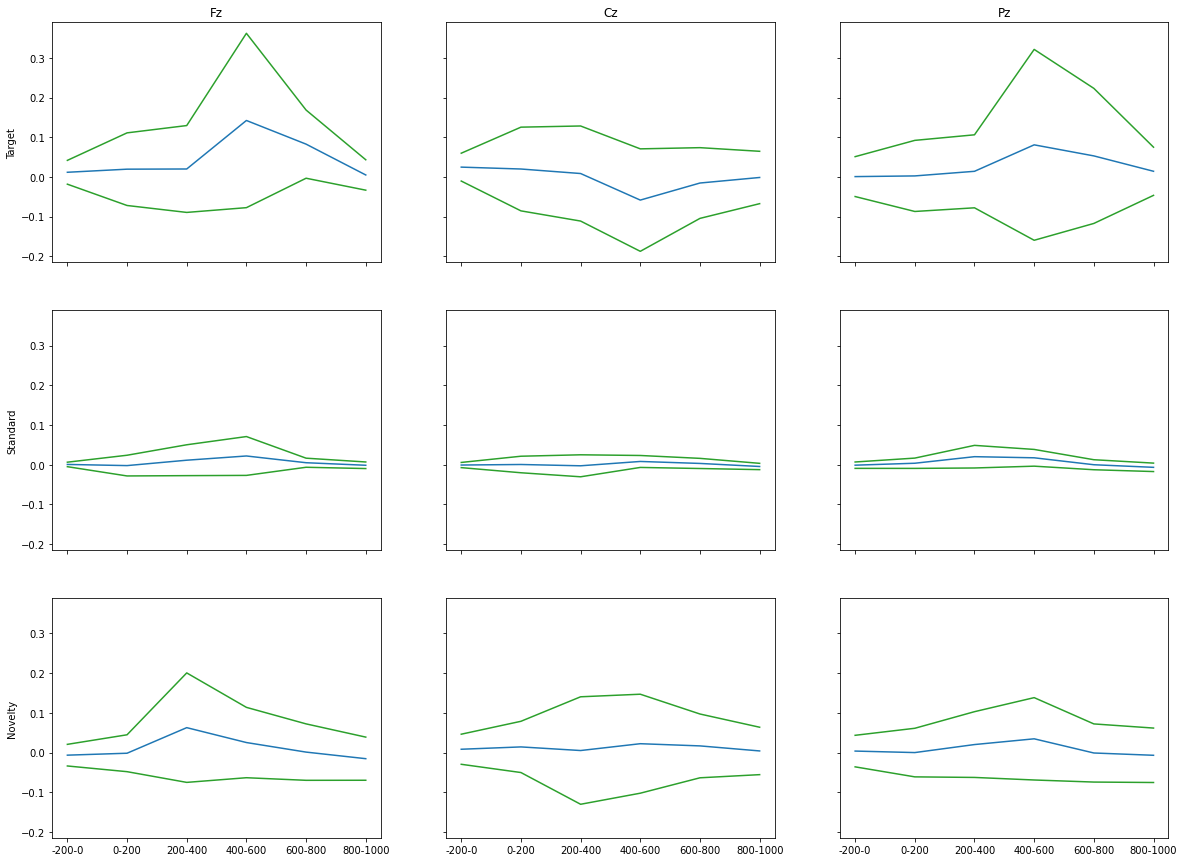

In [ ]:
# , gridspec_kw={'width_ratios': [1, 1]})
fig, axs = plt.subplots(3, 3, figsize=(20, 15), sharex=True, sharey=True)

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

for i, j in np.ndindex((3, 3)):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']
    ax = axs[i, j]

    mvl_selected = (
        mvl_selected_freq_time[1] - mvl_selected_freq_time[0]).mean(axis=0)
    mean = mvl_selected[i, chs[j]]
    std = (mvl_selected_freq_time[1] -
           mvl_selected_freq_time[0]).std(axis=0)[i, chs[j]]

    ax.plot(times, mean, color=colors[0])
    ax.plot(times, mean+std/2, color=colors[2])
    ax.plot(times, mean-std/2, color=colors[2])

    # ax.errorbar(times[1:], mvl_selected, yerr=std/2, color=colors[k],
    #             marker='+', label=groups[k], elinewidth=1, capsize=6)

for i, j in np.ndindex((3, 3)):
    axs[i, 0].set_ylabel(event_types[i])
    axs[0, j].set_title(f'{ch_names[j]}')

    axs[i, j].xaxis.set_visible(True)
    axs[i, j].yaxis.set_visible(True)
    # ax.grid()
    # ax.legend()

plt.savefig('plots/diff_dynamic_time.png')
plt.savefig('plots/diff_dynamic_time.svg')
plt.show()


In [15]:
res = np.zeros((3, 3))
for i, j in np.ndindex((3, 3)):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chs = [1, 23, 12]
    ch_names = ['Fz', 'Cz', 'Pz']

    a, b = list(itertools.combinations(range(3), 2))[i]
    maxind_off = mvl_selected_freq_time[a, :, 0, chs[j], :].argmax(axis=1)
    maxind_on = mvl_selected_freq_time[b, :, 0, chs[j], :].argmax(axis=1)
    if (a, b) == (0, 1):
        t, p = scipy.stats.ttest_rel(maxind_off, maxind_on)
    else:
        t, p = scipy.stats.ttest_ind(maxind_off, maxind_on)
    res[i, j] = p

pd.DataFrame(res, columns=ch_names,
             index=[f'{groups[a]} vs {groups[b]}' for a, b in itertools.combinations(range(3), 2)],)


NameError: name 'mvl_selected_freq_time' is not defined

In [19]:
selected_channels_corss = ['FC3', 'FC4', 'AF3',
                           'AF4', 'F3', 'F4', 'Fz', 'Pz', 'Cz', 'FCz']
selected_channels_corss = ['F3', 'F4', 'FC3', 'FC4', 'Fz', 'Pz', 'Cz']
# selected_channels = config['channels']
if 'VEOG' in selected_channels_corss:
    selected_channels_corss.remove('VEOG')
selected_channels_cross_index = [
    config['channels'].index(ch) for ch in selected_channels_corss]

selected_channels_pairs = [
    #     ('Fz', 'FC3'), ('Fz', 'FC4'),
    #     ('Pz', 'FC3'), ('Pz', 'FC4'),
    #     ('Cz', 'FC3'), ('Cz', 'FC4'),

    ('Fz', 'Fz'), ('Pz', 'Pz'),
    ('Fz', 'F3'), ('Fz', 'F4'),
    ('Pz', 'F3'), ('Pz', 'F4'),
    #     ('Cz', 'F3'), ('Cz', 'F4'),

    #     ('Cz', 'Fz'), ('Cz', 'Pz'),
    #     ('Pz', 'Cz'), ('Fz', 'Cz'),
    #     ('Pz', 'Fz'),
    #     ('Fz', 'Pz'),
]
chpis = [(selected_channels_corss.index(a), selected_channels_corss.index(b))
         for a, b in selected_channels_pairs]
(MVL_cross[1] - MVL_cross[0]).sum(axis=(4, 5)).mean(axis=0).shape


(3, 7, 7, 6)

In [18]:
res = np.zeros((3, len(selected_channels_pairs)))
for i, j in np.ndindex((3, len(selected_channels_pairs))):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    chfh = selected_channels_corss.index(selected_channels_pairs[j][0])
    chfl = selected_channels_corss.index(selected_channels_pairs[j][1])

    a, b = list(itertools.combinations(range(3), 2))[i]
    maxind_off = MVL_cross[a, :, 0, chfh, chfl, :].sum(
        axis=(1, 2)).argmax(axis=1)
    maxind_on = MVL_cross[b, :, 0, chfh, chfl, :].sum(
        axis=(1, 2)).argmax(axis=1)
    if (a, b) == (0, 1):
        t, p = scipy.stats.ttest_rel(maxind_off, maxind_on)
    else:
        t, p = scipy.stats.ttest_ind(maxind_off, maxind_on)
    res[i, j] = p

pd.DataFrame(res, columns=selected_channels_pairs,
             index=[f'{groups[a]} vs {groups[b]}' for a, b in itertools.combinations(range(3), 2)],)


(Fz, Fz)  (Fz, Fz)  (Fz, F3)  (Fz, F4)  (Pz, F3)  \
PD Med Off vs PD Med On  0.152470  0.152470  0.065094  0.904255  0.546912   
PD Med Off vs CTL        0.387309  0.387309  0.401085  0.298441  0.754841   
PD Med On vs CTL         0.536774  0.536774  0.402825  0.364770  0.704695   

                         (Pz, F4)  
PD Med Off vs PD Med On  0.584233  
PD Med Off vs CTL        0.831046  
PD Med On vs CTL         0.755702

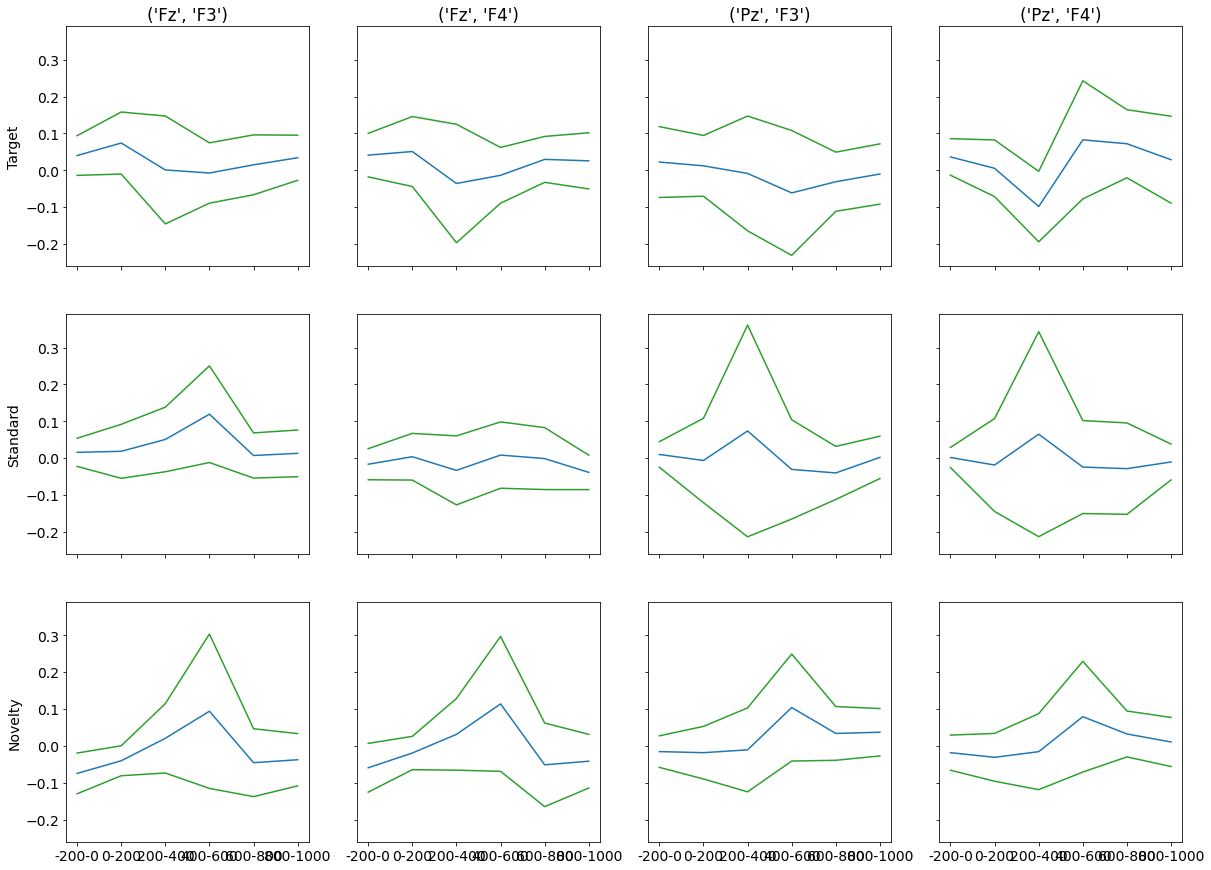

In [ ]:
# , gridspec_kw={'width_ratios': [1, 1]})
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)

times = ['-200-0', '0-200', '200-400', '400-600', '600-800', '800-1000']

# (MVL_cross[1] - MVL_cross[0]).sum(axis=(4, 5))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, j in np.ndindex((3, 4)):
    ax = axs[i, j]

    cha, chb = chpis[j]

    mvl_selected = (MVL_cross[1] - MVL_cross[0]
                    ).sum(axis=(4, 5)).mean(axis=0) / 16
    mean = mvl_selected[i, cha, chb]
    std = (MVL_cross[1] - MVL_cross[0]).sum(axis=(4, 5)
                                            ).std(axis=0)[i, cha, chb] / 16

    ax.plot(times, mean, color=colors[0])
    ax.plot(times, mean+std/2, color=colors[2])
    ax.plot(times, mean-std/2, color=colors[2])

    # ax.errorbar(times[1:], mvl_selected, yerr=std/2, color=colors[k],
    #             marker='+', label=groups[k], elinewidth=1, capsize=6)

for i, j in np.ndindex((3, 4)):
    axs[i, 0].set_ylabel(event_types[i])
    axs[0, j].set_title(f'{selected_channels_pairs[j]}')

    axs[i, j].xaxis.set_visible(True)
    axs[i, j].yaxis.set_visible(True)
    # ax.grid()
    # ax.legend()

plt.savefig('plots/diff_dynamic_cross_time.png')
plt.savefig('plots/diff_dynamic_cross_time.svg')
plt.show()


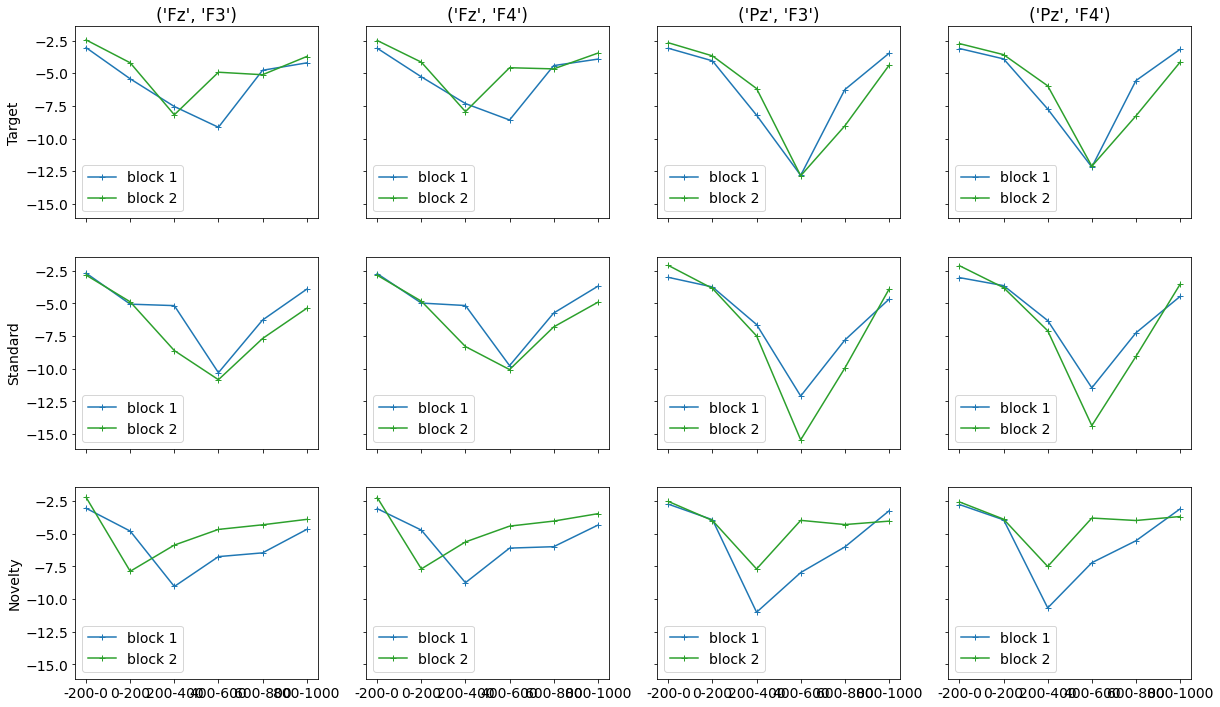

In [ ]:
cols = len(selected_channels_pairs)
fig, axs = plt.subplots(3, cols, figsize=(20, 12), sharex=True, sharey=True)

for i, j in np.ndindex((3, cols)):
    sels = np.ones((25, ), dtype=bool)
    if 1:  # i == 1:
        sels[6] = False
    mvl_selected = mvl_cross_time[i, sels, :, :, :, :, :, :].sum(
        axis=(3, 4))

    dmvl_20 = (mvl_selected[:, 2] - mvl_selected[:, 0]).mean(axis=0)
    dmvl_31 = (mvl_selected[:, 3] - mvl_selected[:, 1]).mean(axis=0)

    std_20 = (mvl_selected[:, 2] - mvl_selected[:, 0]).std(axis=0)
    std_31 = (mvl_selected[:, 3] - mvl_selected[:, 1]).std(axis=0)

    ax = axs[i, j]
    cha, chb = selected_channels_pairs[j]
    inda, indb = selected_channels_corss_2block.index(
        cha), selected_channels_corss_2block.index(chb)

    old_times = np.linspace(-200, 1000, num=6, endpoint=True)
    new_times = np.linspace(-200, 1000, num=101, endpoint=True)
    # f = interp1d(old_times, mvl_selected_1[inda, indb], kind='cubic')
    # f2 = interp1d(old_times, mvl_selected_2[inda, indb], kind='cubic')

    ax.plot(times, dmvl_20[inda, indb], label='block 1', marker='+')
    ax.plot(times, dmvl_31[inda, indb],
            label='block 2', marker='+', c='#2ca02c')
    # ax.plot(new_times, f(new_times), label='block 1 cubic')
    # ax.plot(new_times, f2(new_times), label='block 2 cubic')

    ax.legend()


for i in range(3):
    axs[i, 0].set_ylabel(event_types[i])

for i in range(cols):
    axs[0, i].set_title(selected_channels_pairs[i])

#     axs[-1, i].xaxis.set_visible(True)
#     axs[i, 0].yaxis.set_visible(True)

    #     cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    #     clb = fig.colorbar(im, cax=cbar_ax)

    #     axs[2, 1].set_xlabel(times[time])

plt.savefig('plots/2blocks_pac_4channels_diff.svg')
plt.savefig('plots/2blocks_pac_4channels_diff.png')
plt.show()


(24, 3, 7, 4, 6)